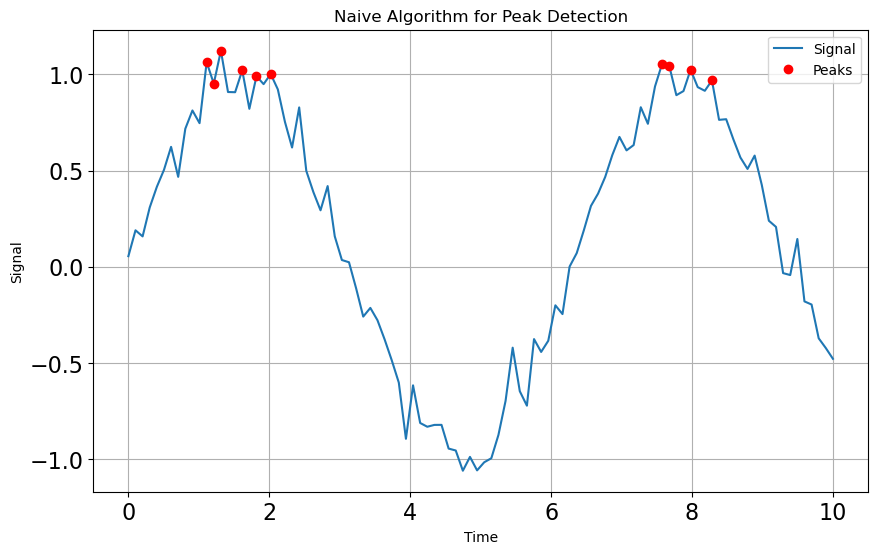

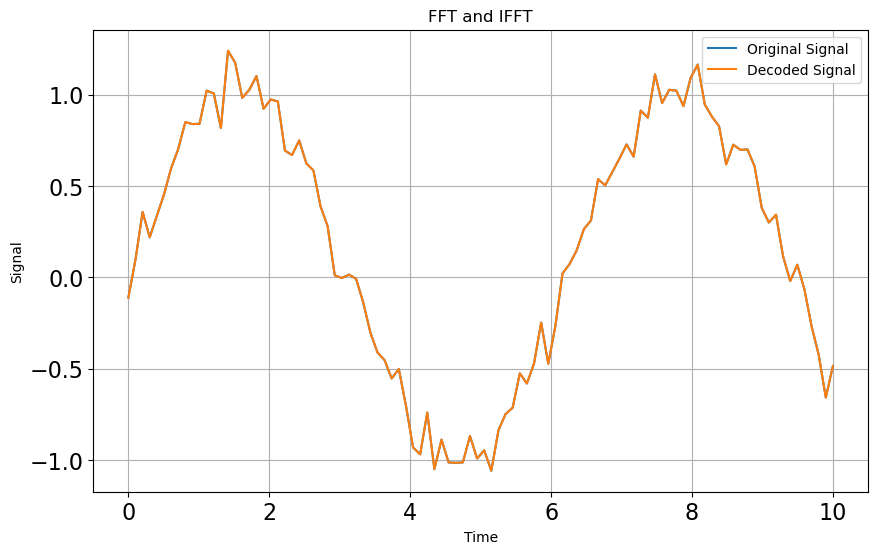

In [59]:
# Generate the time series of some random signal and plot red markers on its peak
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, x.shape)
# Select only top 10 peaks in terms of highest value not the index
# peaks = np.where((y[1:-1] > y[:-2]) & (y[1:-1] > y[2:]))[0] + 1
peaks = np.argsort(y)[-10:]
# MAke sure that plot is presentatble in slide show so add proper legends, incresae font size, add grid, add title, better tick marks, tick fonts
plt.figure(figsize=(10, 6))
plt.plot(x, y)
# peaks = peaks[:10]
plt.plot(x[peaks], y[peaks], 'ro')
plt.grid()
plt.title('Naive Algorithm for Peak Detection')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Signal', 'Peaks'])
plt.show()


# For the same signal, first encode the signal and then decode it back to original signal using FFT
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, x.shape)
# Encode the signal using FFT
Y = np.fft.fft(y)
# Decode the signal using IFFT
y_ = np.fft.ifft(Y)
# Make sure that plot is presentatble in slide show so add proper legends, incresae font size, add grid, add title, better tick marks, tick fonts
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.plot(x, y_)
plt.grid()
plt.title('FFT and IFFT')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Original Signal', 'Decoded Signal'])
plt.show()

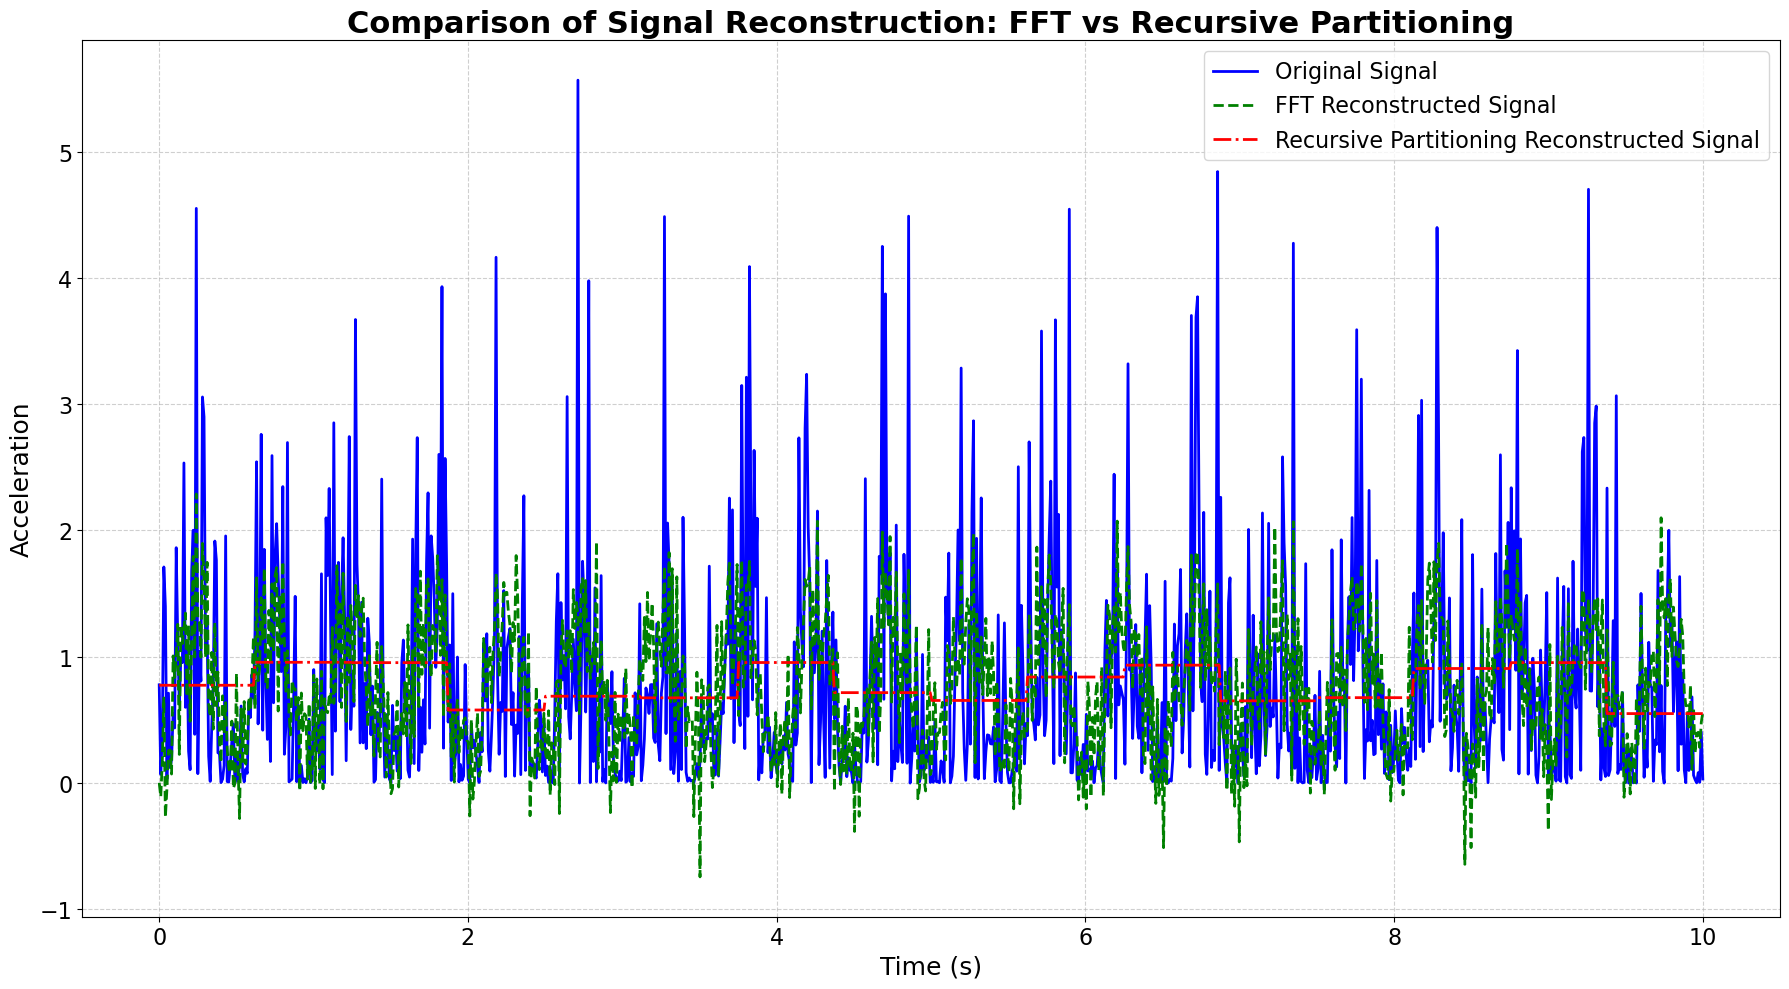

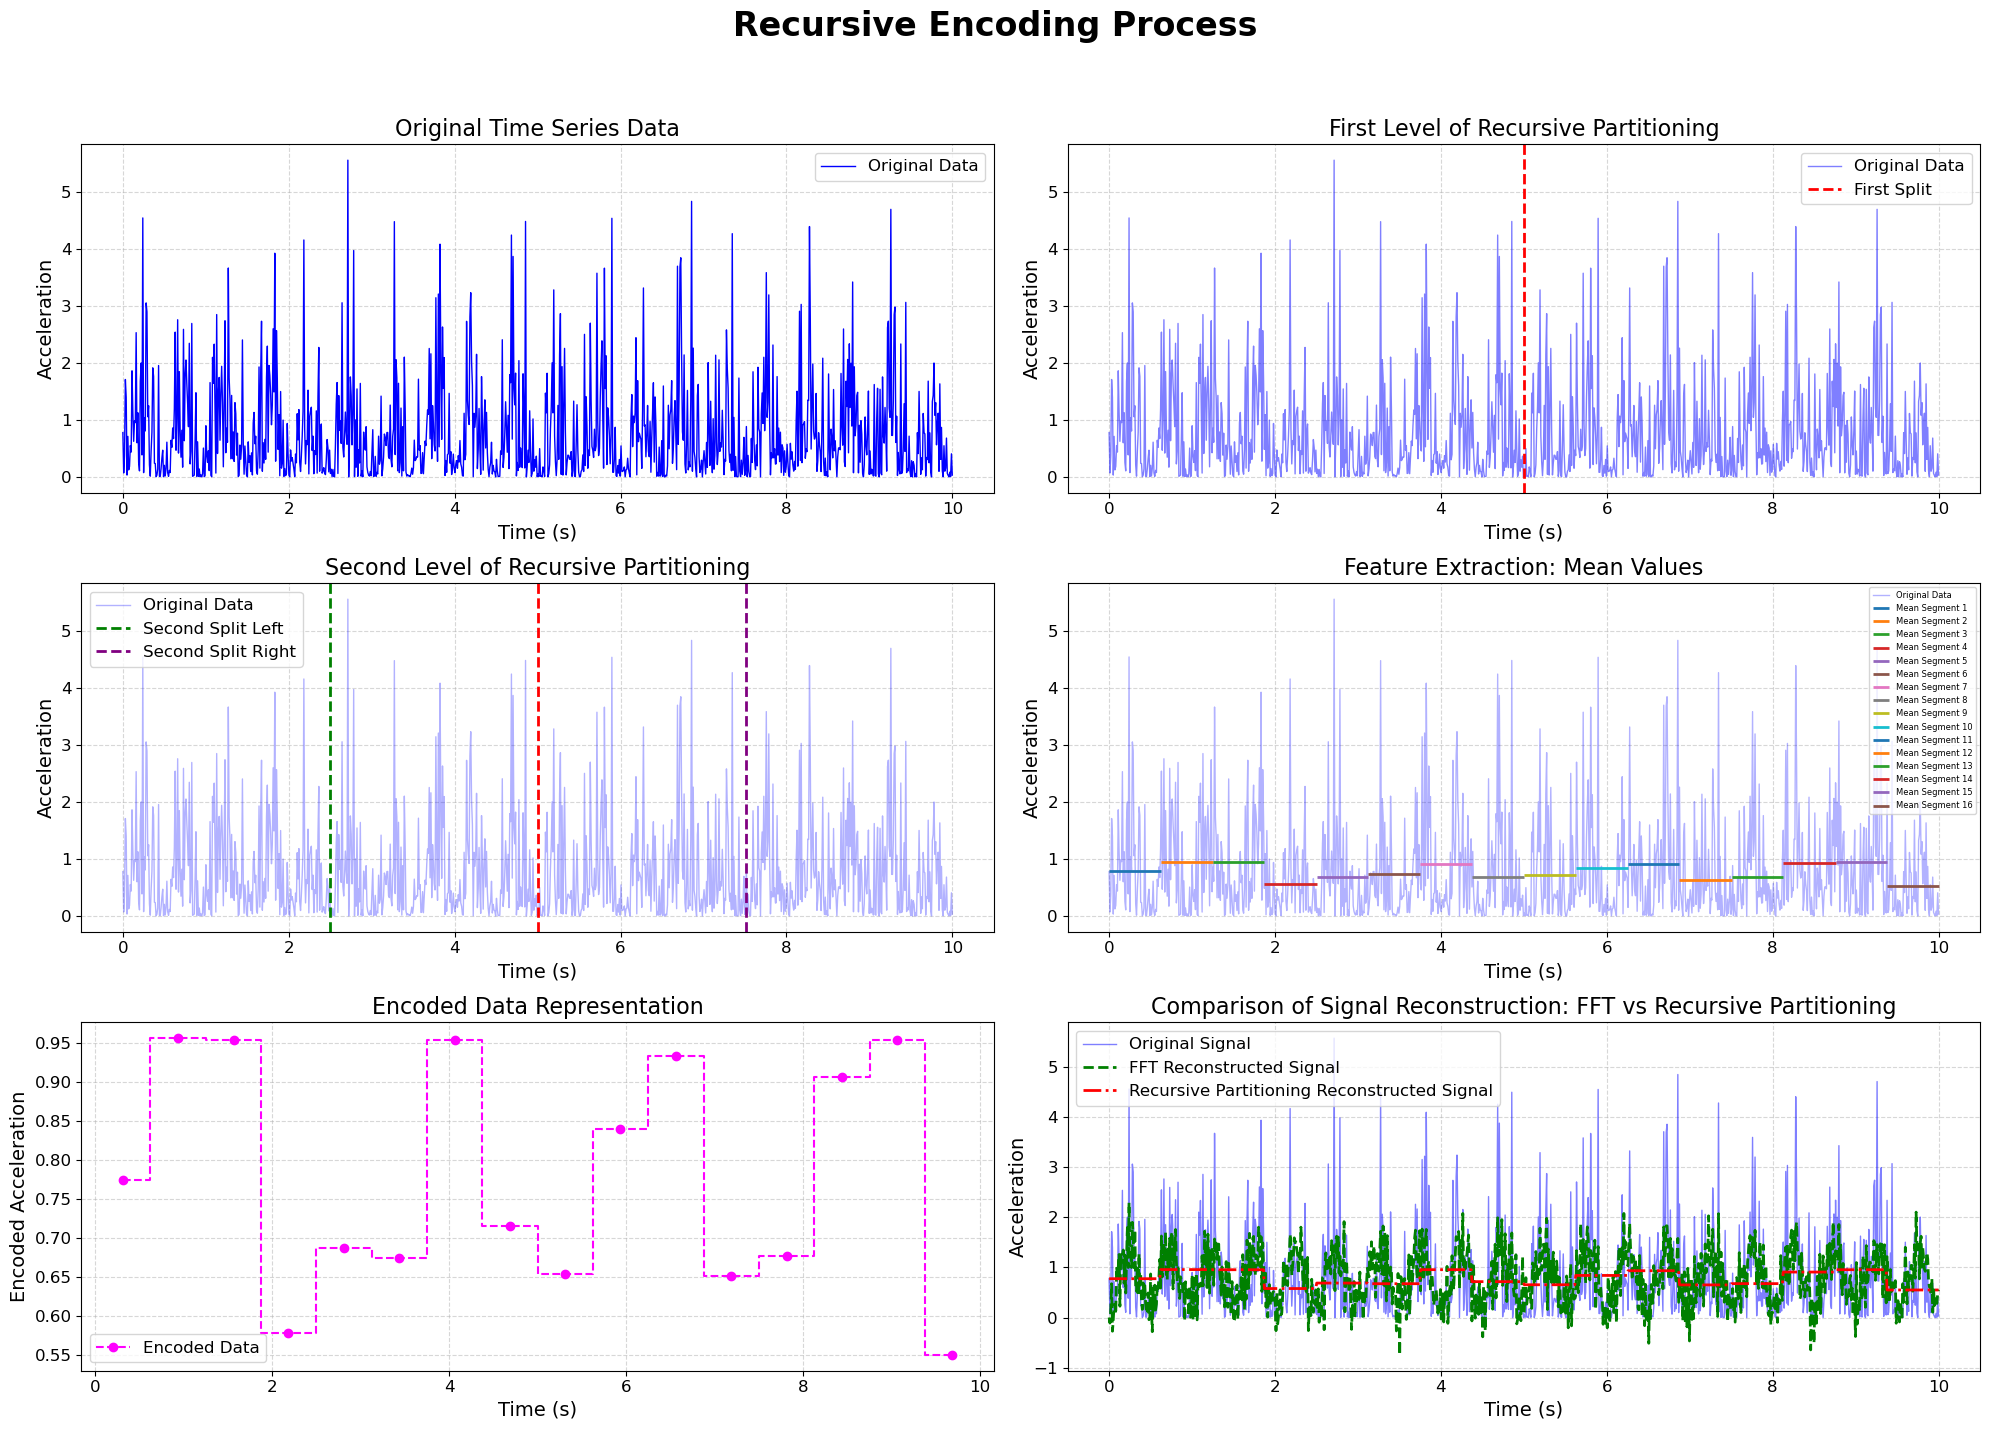

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# ------------------ 1. Generate Sample Time Series Data ------------------
# Replace 'x' and 'y' with your actual data if available
# For demonstration, we'll generate synthetic data
np.random.seed(0)  # For reproducibility
time = np.linspace(0, 10, 1000)  # 10 seconds sampled at 100 Hz
time_series = np.sin(2 * np.pi * 1 * time) + 0.5 * np.random.randn(len(time))  # 1 Hz sine wave with noise

# take square of the signal to make it positive
time_series = time_series**2

# ------------------ 2. Recursive Partitioning Encoding/Decoding ------------------
def recursive_encode(data, threshold=250):
    if len(data) <= threshold:
        return [np.mean(data)]  # Encoding with max value as a feature
    
    mid = len(data) // 2
    left_encoded = recursive_encode(data[:mid], threshold)
    right_encoded = recursive_encode(data[mid:], threshold)
    
    return left_encoded + right_encoded

def recursive_decode(encoded_data, original_length, threshold=250):
    if len(encoded_data) == 1:
        return np.full(original_length, encoded_data[0])
    
    half_length = original_length // 2
    left_decoded = recursive_decode(encoded_data[:len(encoded_data)//2], half_length, threshold)
    right_decoded = recursive_decode(encoded_data[len(encoded_data)//2:], original_length - half_length, threshold)
    
    combined_decoded = np.concatenate((left_decoded, right_decoded))
    return combined_decoded[:original_length]  # Ensure consistent length

# Perform Recursive Encoding and Decoding
threshold = len(time_series) // 10  # Adjust threshold as needed (e.g., 100)
encoded_recursive = recursive_encode(time_series, threshold=threshold)
decoded_recursive = recursive_decode(encoded_recursive, len(time_series), threshold=threshold)

# ------------------ 3. FFT-Based Encoding/Decoding ------------------
def fft_encode(data, num_coefficients=50):
    # Perform FFT
    fft_coeffs = fft(data)
    
    # Zero out all but the top 'num_coefficients' by magnitude
    indices = np.argsort(np.abs(fft_coeffs))[-num_coefficients:]
    fft_compressed = np.zeros_like(fft_coeffs)
    fft_compressed[indices] = fft_coeffs[indices]
    
    return fft_compressed

def fft_decode(compressed_fft):
    # Perform inverse FFT
    reconstructed = ifft(compressed_fft)
    return np.real(reconstructed)  # Discard the imaginary part

# Perform FFT Encoding and Decoding
compressed_fft = fft_encode(time_series, num_coefficients=50)
decoded_fft = fft_decode(compressed_fft)

# ------------------ 4. Plotting the Comparison ------------------
plt.figure(figsize=(18, 10))  # Large figure for clear visibility

# Plot Original Signal
plt.plot(time, time_series, label="Original Signal", color='blue', linewidth=2)

# Plot FFT Reconstructed Signal
plt.plot(time, decoded_fft, label="FFT Reconstructed Signal", linestyle='--', color='green', linewidth=2)

# Plot Recursive Partitioning Reconstructed Signal
plt.plot(time, decoded_recursive, label="Recursive Partitioning Reconstructed Signal", linestyle='-.', color='red', linewidth=2)

# Enhancements for Better Visibility on Slides
plt.xlabel("Time (s)", fontsize=18)
plt.ylabel("Acceleration", fontsize=18)
plt.title("Comparison of Signal Reconstruction: FFT vs Recursive Partitioning", fontsize=22, fontweight='bold')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("final_comparison_reconstruction.png", dpi=300)
plt.show()

# ------------------ 5. Plotting the Encoding Process with Subplots ------------------
# Split the data into segments based on recursive encoding
def split_segments(data, num_segments):
    return np.array_split(data, num_segments)

num_segments = len(encoded_recursive)
segments = split_segments(time_series, num_segments)
mean_values = [np.mean(seg) for seg in segments]

# Create Subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 15))  # 3 rows x 2 columns
fig.suptitle("Recursive Encoding Process", fontsize=24, fontweight='bold')

# ------------------ Subplot 1: Original Time Series ------------------
axs[0, 0].plot(time, time_series, label="Original Data", color='blue', linewidth=1)
axs[0, 0].set_title("Original Time Series Data", fontsize=16)
axs[0, 0].set_xlabel("Time (s)", fontsize=14)
axs[0, 0].set_ylabel("Acceleration", fontsize=14)
axs[0, 0].legend(fontsize=12)
axs[0, 0].tick_params(axis='both', which='major', labelsize=12)
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# ------------------ Subplot 2: First Level Partitioning ------------------
mid = len(time_series) // 2
axs[0, 1].plot(time, time_series, label="Original Data", color='blue', alpha=0.5, linewidth=1)
axs[0, 1].axvline(x=time[mid], color='red', linestyle='--', label="First Split", linewidth=2)
axs[0, 1].set_title("First Level of Recursive Partitioning", fontsize=16)
axs[0, 1].set_xlabel("Time (s)", fontsize=14)
axs[0, 1].set_ylabel("Acceleration", fontsize=14)
axs[0, 1].legend(fontsize=12)
axs[0, 1].tick_params(axis='both', which='major', labelsize=12)
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# ------------------ Subplot 3: Second Level Partitioning ------------------
mid1 = len(time_series[:mid]) // 2
mid2 = len(time_series[mid:]) // 2
axs[1, 0].plot(time, time_series, label="Original Data", color='blue', alpha=0.3, linewidth=1)
axs[1, 0].axvline(x=time[mid], color='red', linestyle='--', linewidth=2)
axs[1, 0].axvline(x=time[mid1], color='green', linestyle='--', label="Second Split Left", linewidth=2)
axs[1, 0].axvline(x=time[mid + mid2], color='purple', linestyle='--', label="Second Split Right", linewidth=2)
axs[1, 0].set_title("Second Level of Recursive Partitioning", fontsize=16)
axs[1, 0].set_xlabel("Time (s)", fontsize=14)
axs[1, 0].set_ylabel("Acceleration", fontsize=14)
axs[1, 0].legend(fontsize=12)
axs[1, 0].tick_params(axis='both', which='major', labelsize=12)
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# ------------------ Subplot 4: Feature Extraction ------------------
axs[1, 1].plot(time, time_series, label="Original Data", color='blue', alpha=0.3, linewidth=1)

for i, max_val in enumerate(mean_values):
    start_idx = i * len(time_series) // num_segments
    end_idx = (i + 1) * len(time_series) // num_segments

    # Prevent index out of bounds for the last segment
    if end_idx >= len(time_series):
        end_idx = len(time_series) - 1

    start_time = time[start_idx]
    end_time = time[end_idx]

    axs[1, 1].hlines(y=max_val, xmin=start_time, xmax=end_time, colors='C{}'.format(i), linestyles='-', linewidth=2, label=f"Mean Segment {i+1}")

axs[1, 1].set_title("Feature Extraction: Mean Values", fontsize=16)
axs[1, 1].set_xlabel("Time (s)", fontsize=14)
axs[1, 1].set_ylabel("Acceleration", fontsize=14)
axs[1, 1].legend(fontsize=6, loc='upper right')
axs[1, 1].tick_params(axis='both', which='major', labelsize=12)
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

# ------------------ Subplot 5: Encoded Data Representation ------------------
# Calculate the center time of each segment for plotting
encoded_time = [time[i * len(time_series) // num_segments + len(seg)//2] for i, seg in enumerate(segments)]
axs[2, 0].step(encoded_time, encoded_recursive, where='mid', label="Encoded Data", linestyle='--', marker='o', color='magenta')
axs[2, 0].set_title("Encoded Data Representation", fontsize=16)
axs[2, 0].set_xlabel("Time (s)", fontsize=14)
axs[2, 0].set_ylabel("Encoded Acceleration", fontsize=14)
axs[2, 0].legend(fontsize=12)
axs[2, 0].tick_params(axis='both', which='major', labelsize=12)
axs[2, 0].grid(True, linestyle='--', alpha=0.5)

# ------------------ Subplot 6: Reconstructed Signals Comparison ------------------
axs[2, 1].plot(time, time_series, label="Original Signal", color='blue', alpha=0.5, linewidth=1)
axs[2, 1].plot(time, decoded_fft, label="FFT Reconstructed Signal", linestyle='--', color='green', linewidth=2)
axs[2, 1].plot(time, decoded_recursive, label="Recursive Partitioning Reconstructed Signal", linestyle='-.', color='red', linewidth=2)
axs[2, 1].set_title("Comparison of Signal Reconstruction: FFT vs Recursive Partitioning", fontsize=16)
axs[2, 1].set_xlabel("Time (s)", fontsize=14)
axs[2, 1].set_ylabel("Acceleration", fontsize=14)
axs[2, 1].legend(fontsize=12)
axs[2, 1].tick_params(axis='both', which='major', labelsize=12)
axs[2, 1].grid(True, linestyle='--', alpha=0.5)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust rect to accommodate the main title
plt.savefig("encoding_process_subplots.png", dpi=300)
plt.show()


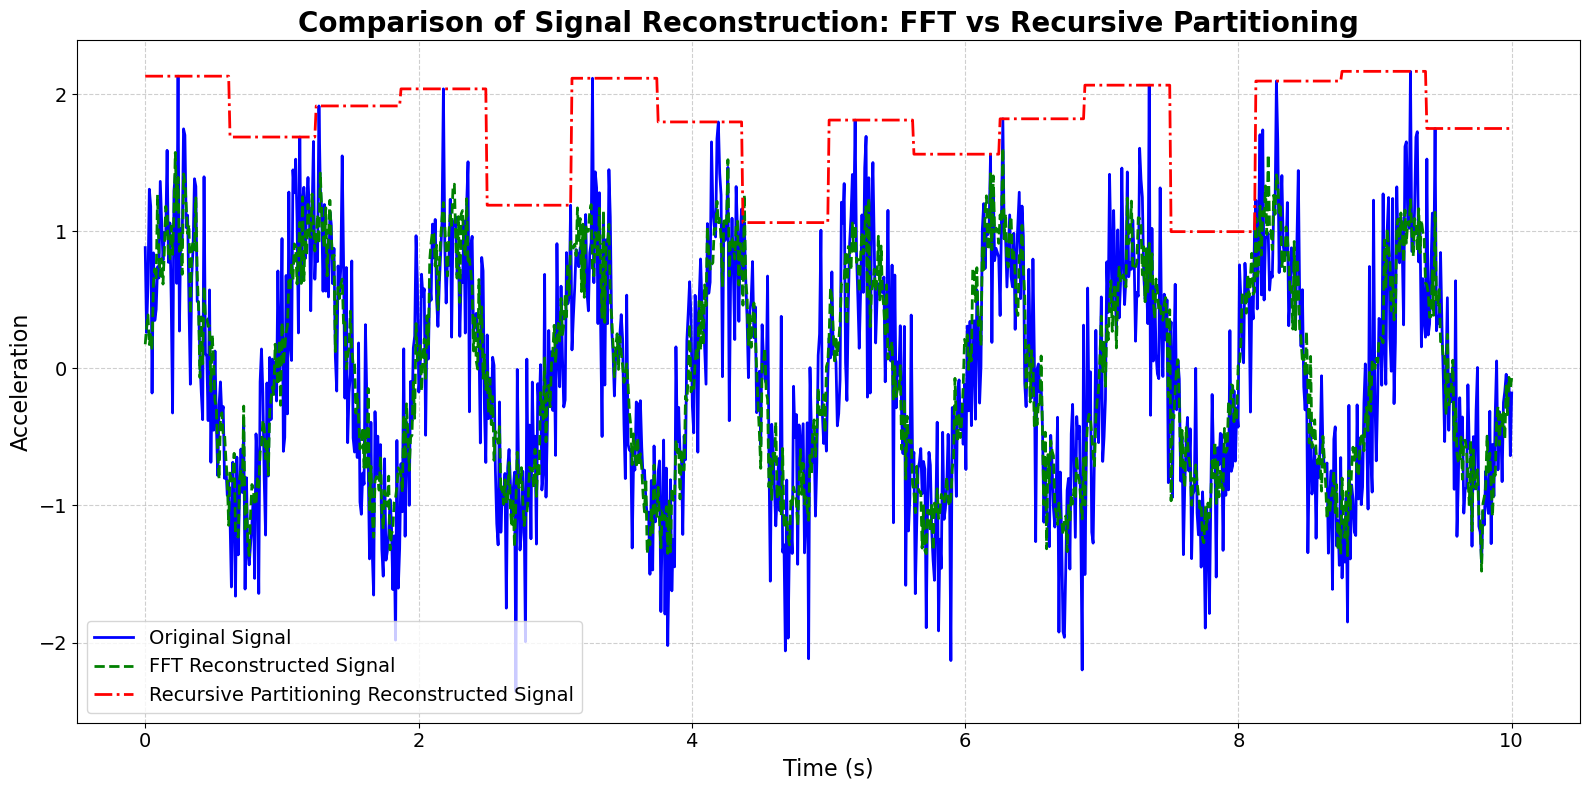

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# ------------------ 1. Generate Sample Time Series Data ------------------
np.random.seed(0)  # For reproducibility
time = np.linspace(0, 10, 1000)  # 10 seconds sampled at 100 Hz
time_series = np.sin(2 * np.pi * 1 * time) + 0.5 * np.random.randn(len(time))  # 1 Hz sine wave with noise

# ------------------ 2. Recursive Partitioning Encoding/Decoding ------------------
def recursive_encode(data, threshold=250):
    if len(data) <= threshold:
        return [np.max(data)]  # Encoding with max value as a feature
    
    mid = len(data) // 2
    left_encoded = recursive_encode(data[:mid], threshold)
    right_encoded = recursive_encode(data[mid:], threshold)
    
    return left_encoded + right_encoded

def recursive_decode(encoded_data, original_length, threshold=250):
    if len(encoded_data) == 1:
        return np.full(original_length, encoded_data[0])
    
    half_length = original_length // 2
    left_decoded = recursive_decode(encoded_data[:len(encoded_data)//2], half_length, threshold)
    right_decoded = recursive_decode(encoded_data[len(encoded_data)//2:], original_length - half_length, threshold)
    
    combined_decoded = np.concatenate((left_decoded, right_decoded))
    return combined_decoded[:original_length]  # Ensure consistent length

import numpy as np

def calculate_threshold(time_series, alpha=10, epsilon=1e-5):
    sigma = np.std(time_series)
    entropy = -np.sum((time_series / np.sum(time_series)) * np.log(time_series / np.sum(time_series) + epsilon))
    # Combine measures; weights can be tuned based on application
    threshold = len(time_series) / (alpha * (sigma + entropy + epsilon))
    return int(threshold)

# Usage
# # threshold = calculate_threshold(time_series, alpha=10)
# encoded_recursive = recursive_encode(time_series, threshold=threshold)
# decoded_recursive = recursive_decode(encoded_recursive, len(time_series), threshold=threshold)

# # Perform Recursive Encoding and Decoding
threshold = len(time_series) // 10  # Adjust threshold as needed
encoded_recursive = recursive_encode(time_series, threshold=threshold)
decoded_recursive = recursive_decode(encoded_recursive, len(time_series), threshold=threshold)

# ------------------ 3. FFT-Based Encoding/Decoding ------------------
def fft_encode(data, num_coefficients=50):
    # Perform FFT
    fft_coeffs = fft(data)
    
    # Zero out all but the top 'num_coefficients' by magnitude
    indices = np.argsort(np.abs(fft_coeffs))[-num_coefficients:]
    fft_compressed = np.zeros_like(fft_coeffs)
    fft_compressed[indices] = fft_coeffs[indices]
    
    return fft_compressed

def fft_decode(compressed_fft):
    # Perform inverse FFT
    reconstructed = ifft(compressed_fft)
    return np.real(reconstructed)  # Discard the imaginary part

# Perform FFT Encoding and Decoding
compressed_fft = fft_encode(time_series, num_coefficients=50)
decoded_fft = fft_decode(compressed_fft)

# ------------------ 4. Plotting the Comparison ------------------
plt.figure(figsize=(16, 8))

# Plot Original Signal
plt.plot(time, time_series, label="Original Signal", color='blue', linewidth=2)

# Plot FFT Reconstructed Signal
plt.plot(time, decoded_fft, label="FFT Reconstructed Signal", linestyle='--', color='green', linewidth=2)

# Plot Recursive Partitioning Reconstructed Signal
plt.plot(time, decoded_recursive, label="Recursive Partitioning Reconstructed Signal", linestyle='-.', color='red', linewidth=2)

# Enhancements for Better Visibility on Slides
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Acceleration", fontsize=16)
plt.title("Comparison of Signal Reconstruction: FFT vs Recursive Partitioning", fontsize=20, fontweight='bold')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("comparison_reconstruction.png", dpi=300)
plt.show()


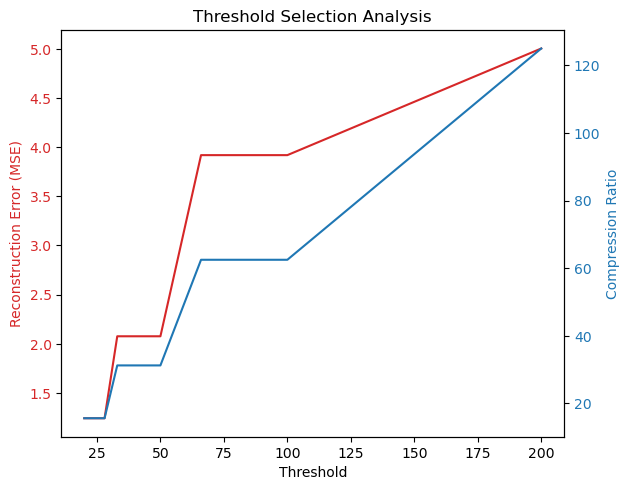

In [62]:
thresholds = [len(time_series) // i for i in range(5, 51, 5)]  # Thresholds from len/5 to len/50
reconstruction_errors = []
compression_ratios = []

for threshold in thresholds:
    encoded_recursive = recursive_encode(time_series, threshold=threshold)
    decoded_recursive = recursive_decode(encoded_recursive, len(time_series), threshold=threshold)

    # Compute reconstruction error
    mse = np.mean((time_series - decoded_recursive) ** 2)
    reconstruction_errors.append(mse)

    # Compute compression ratio
    original_size = len(time_series) * time_series.itemsize
    encoded_size = len(encoded_recursive) * encoded_recursive[0].itemsize
    compression_ratio = original_size / encoded_size
    compression_ratios.append(compression_ratio)
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Reconstruction Error (MSE)', color=color)
ax1.plot(thresholds, reconstruction_errors, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Compression Ratio', color=color)
ax2.plot(thresholds, compression_ratios, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Threshold Selection Analysis')
plt.show()


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from sklearn.metrics import mean_squared_error
import time
import sys
import psutil
from tqdm import tqdm  # For progress bars
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ------------------ 2. Define Necessary Functions ------------------

# Recursive Encoding Function
def recursive_encode(data, threshold=1000):
    """
    Recursively encodes the data by splitting it until each segment's length
    is less than or equal to the threshold. Each segment is represented by its maximum value.
    """
    if len(data) <= threshold:
        return [np.max(data)]  # Encoding with max value as a feature
    
    mid = len(data) // 2
    left_encoded = recursive_encode(data[:mid], threshold)
    right_encoded = recursive_encode(data[mid:], threshold)
    
    return left_encoded + right_encoded

# Recursive Decoding Function
def recursive_decode(encoded_data, original_length, threshold=1000):
    """
    Recursively decodes the encoded data by expanding each encoded value back to its segment length.
    """
    if len(encoded_data) == 1:
        return np.full(original_length, encoded_data[0])
    
    half_length = original_length // 2
    left_decoded = recursive_decode(encoded_data[:len(encoded_data)//2], half_length, threshold)
    right_decoded = recursive_decode(encoded_data[len(encoded_data)//2:], original_length - half_length, threshold)
    
    combined_decoded = np.concatenate((left_decoded, right_decoded))
    return combined_decoded[:original_length]  # Ensure consistent length

# FFT Encoding Function
def fft_encode(data, num_coefficients=50):
    """
    Encodes the data using FFT by retaining the top 'num_coefficients' frequency components.
    """
    fft_coeffs = fft(data)
    indices = np.argsort(np.abs(fft_coeffs))[-num_coefficients:]
    fft_compressed = np.zeros_like(fft_coeffs)
    fft_compressed[indices] = fft_coeffs[indices]
    return fft_compressed

# FFT Decoding Function
def fft_decode(compressed_fft):
    """
    Decodes the FFT-compressed data by performing an inverse FFT.
    """
    reconstructed = ifft(compressed_fft)
    return np.real(reconstructed)  # Discard the imaginary part

# Peak Signal-to-Noise Ratio Function
def psnr(true, pred):
    """
    Calculates the Peak Signal-to-Noise Ratio between the true and predicted signals.
    """
    mse = mean_squared_error(true, pred)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(1/mse)

# Memory Usage Function
def memory_usage(obj):
    """
    Estimates the memory usage of a Python object in bytes.
    """
    process = psutil.Process()
    mem_before = process.memory_info().rss
    _ = obj  # Reference the object
    mem_after = process.memory_info().rss
    return mem_after - mem_before  # Return memory used by the object

# Runtime Measurement Function
def measure_runtime(func, data, threshold=1000):
    """
    Measures the runtime of a function.
    """
    start_time = time.perf_counter_ns()
    func(data, threshold)
    end_time = time.perf_counter_ns()
    return end_time - start_time  # Runtime in nanoseconds

# ------------------ 3. Define the Main Processing Function ------------------

def func_kaggle(data: np.array, THRESHOLD=1000):
    """
    Processes the data using both Recursive Partitioning and FFT-based encoding/decoding.
    Returns performance metrics for both methods.
    """
    # Initialize metrics
    mse_gbrt = mse_fft = memory_gbrt = memory_fft = runtime_fft = runtime_gbrt = fft_psnr = gbrt_psnr = 0
    
    # Measure Recursive Partitioning
    start_time = time.perf_counter_ns()
    encoded = recursive_encode(data, threshold=THRESHOLD)
    decoded = recursive_decode(encoded, len(data), threshold=THRESHOLD)
    end_time = time.perf_counter_ns()
    runtime_gbrt = end_time - start_time  # in nanoseconds
    mse_gbrt = mean_squared_error(data, decoded)
    memory_gbrt = memory_usage(encoded)
    gbrt_psnr = psnr(data, decoded)
    
    # Measure FFT-based Encoding/Decoding
    start_time = time.perf_counter_ns()
    fft_encoded = fft_encode(data)
    fft_decoded = fft_decode(fft_encoded)
    end_time = time.perf_counter_ns()
    runtime_fft = end_time - start_time  # in nanoseconds
    mse_fft = mean_squared_error(data, fft_decoded)
    memory_fft = memory_usage(fft_encoded)
    fft_psnr = psnr(data, fft_decoded)
    
    # Print Summary of Results
    print("Summary of Results")
    print("------------------")
    print(f"{'Metric':<15}{'Recursive':<20}{'FFT':<20}")
    print(f"{'MSE':<15}{mse_gbrt:<20.6f}{mse_fft:<20.6f}")
    print(f"{'PSNR':<15}{gbrt_psnr:<20.2f}{fft_psnr:<20.2f}")
    print(f"{'Memory (bytes)':<15}{memory_gbrt:<20}{memory_fft:<20}")
    print(f"{'Runtime (ns)':<15}{runtime_gbrt:<20}{runtime_fft:<20}")
    
    return mse_fft, mse_gbrt, memory_fft, memory_gbrt, runtime_fft, runtime_gbrt, fft_psnr, gbrt_psnr

# ------------------ 4. Define the Plotting Function ------------------

def plot_results(pd_results):
    """
    Plots the MSE, Memory Usage, and Runtime for Recursive Partitioning and FFT-based methods.
    """
    # Define colors and markers for consistency
    colors = {'FFT': 'green', 'Recursive': 'red'}
    markers = {'FFT': 's', 'Recursive': 'o'}
    
    plt.figure(figsize=(18, 6))
    
    # ------------------ Subplot 1: MSE ------------------
    plt.subplot(1, 3, 1)
    plt.plot(pd_results["Threshold"], pd_results["FFT_MSE"], label="FFT", marker='s', color=colors['FFT'])
    plt.plot(pd_results["Threshold"], pd_results["Recursive_MSE"], label="Recursive", marker='o', color=colors['Recursive'])
    plt.title("Mean Squared Error (MSE)", fontsize=14)
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("MSE", fontsize=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
    
    # ------------------ Subplot 2: Memory Usage ------------------
    plt.subplot(1, 3, 2)
    plt.plot(pd_results["Threshold"], pd_results["FFT_Memory"], label="FFT", marker='s', color=colors['FFT'])
    plt.plot(pd_results["Threshold"], pd_results["Recursive_Memory"], label="Recursive", marker='o', color=colors['Recursive'])
    plt.title("Memory Usage (bytes)", fontsize=14)
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Memory Usage (bytes)", fontsize=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
    
    # ------------------ Subplot 3: Runtime ------------------
    plt.subplot(1, 3, 3)
    plt.plot(pd_results["Threshold"], pd_results["FFT_Runtime"], label="FFT", marker='s', color=colors['FFT'])
    plt.plot(pd_results["Threshold"], pd_results["Recursive_Runtime"], label="Recursive", marker='o', color=colors['Recursive'])
    plt.title("Runtime (nanoseconds)", fontsize=14)
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Runtime (ns)", fontsize=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()
    plt.savefig("runtime_memory_comparison_real_dataset.png", dpi=300)
    plt.show()


In [64]:
# ------------------ 4. Load and Preprocess the Dataset ------------------

import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('train.csv')

# Display the first few rows to understand the structure
print(data.head())

# Randomly select 1000 rows from the data for processing
data = data.sample(1000, random_state=42)  # Setting a random state for reproducibility

# Drop any rows with missing values
data = data.dropna()

# Reset the index after sampling
data = data.reset_index(drop=True)

# Convert the data to a NumPy array
data = data.to_numpy()

# Exclude the last two columns (assuming they are non-essential)
data = data[:, :-2]

print(f"Data shape after preprocessing: {data.shape}")


   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

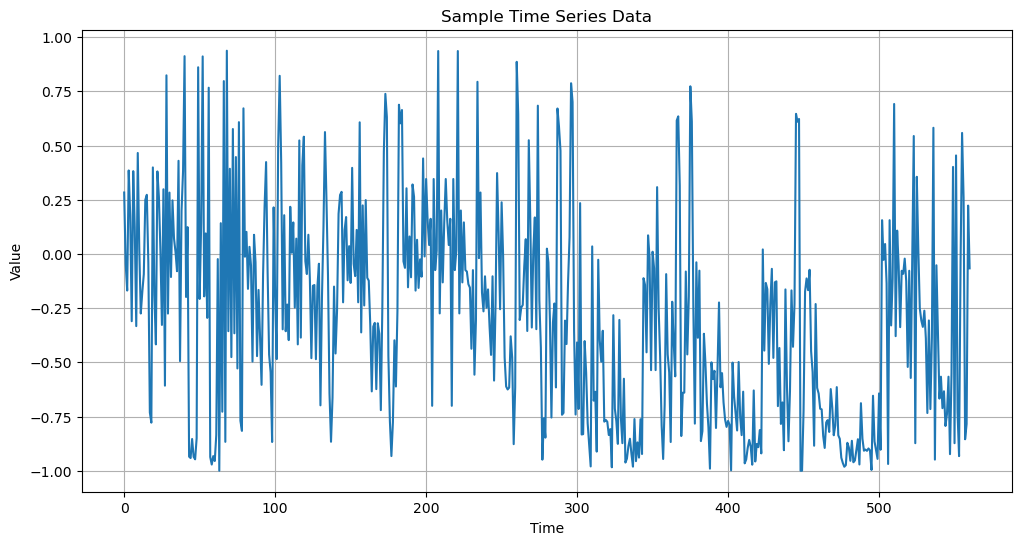

In [65]:
# Plot the sample time series data
plt.figure(figsize=(12, 6))
plt.plot(data[0, :])
plt.title("Sample Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()



Running experiments for Threshold = 1


Threshold 1:   3%|▎         | 33/1000 [00:00<00:02, 329.89it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.110131            
PSNR           inf                 9.58                
Memory (bytes) 0                   0                   
Runtime (ns)   3080600             133000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.111211            
PSNR           inf                 9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   2951300             79200               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.087748            
PSNR           inf                 10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   2203800             62800               
Summary of Results
------------------
Metric  

Threshold 1:  10%|█         | 100/1000 [00:00<00:02, 330.33it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.083698            
PSNR           inf                 10.77               
Memory (bytes) 0                   0                   
Runtime (ns)   2973700             209500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.092351            
PSNR           inf                 10.35               
Memory (bytes) 0                   0                   
Runtime (ns)   2661000             179300              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.100389            
PSNR           inf                 9.98                
Memory (bytes) 0                   0                   
Runtime (ns)   2137400             64200               
Summary of Results
------------------
Metric  

Threshold 1:  20%|██        | 202/1000 [00:00<00:02, 328.54it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.101906            
PSNR           inf                 9.92                
Memory (bytes) 0                   0                   
Runtime (ns)   3115700             139900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.105022            
PSNR           inf                 9.79                
Memory (bytes) 0                   0                   
Runtime (ns)   2439000             162500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.092689            
PSNR           inf                 10.33               
Memory (bytes) 0                   0                   
Runtime (ns)   2145500             59500               
Summary of Results
------------------
Metric  

Threshold 1:  27%|██▋       | 268/1000 [00:00<00:02, 324.86it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.098673            
PSNR           inf                 10.06               
Memory (bytes) 0                   0                   
Runtime (ns)   2769900             138800              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.098260            
PSNR           inf                 10.08               
Memory (bytes) 0                   0                   
Runtime (ns)   2506300             63700               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.100463            
PSNR           inf                 9.98                
Memory (bytes) 0                   0                   
Runtime (ns)   2171800             59900               
Summary of Results
------------------
Metric  

Threshold 1:  33%|███▎      | 334/1000 [00:01<00:02, 324.78it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.103028            
PSNR           inf                 9.87                
Memory (bytes) 0                   0                   
Runtime (ns)   3010200             63500               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.101219            
PSNR           inf                 9.95                
Memory (bytes) 0                   0                   
Runtime (ns)   2749400             60800               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.100569            
PSNR           inf                 9.98                
Memory (bytes) 0                   0                   
Runtime (ns)   2155100             59900               
Summary of Results
------------------
Metric  

Threshold 1:  37%|███▋      | 367/1000 [00:01<00:01, 324.10it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.094707            
PSNR           inf                 10.24               
Memory (bytes) 0                   0                   
Runtime (ns)   2670200             195000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.095226            
PSNR           inf                 10.21               
Memory (bytes) 0                   0                   
Runtime (ns)   2205600             60900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.103230            
PSNR           inf                 9.86                
Memory (bytes) 0                   0                   
Runtime (ns)   2160400             91200               
Summary of Results
------------------
Metric  

Threshold 1:  43%|████▎     | 434/1000 [00:01<00:01, 327.97it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.103443            
PSNR           inf                 9.85                
Memory (bytes) 0                   0                   
Runtime (ns)   2791400             179400              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.088817            
PSNR           inf                 10.52               
Memory (bytes) 0                   0                   
Runtime (ns)   2887500             64000               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.085151            
PSNR           inf                 10.70               
Memory (bytes) 0                   0                   
Runtime (ns)   2136500             58100               
Summary of Results
------------------
Metric  

Threshold 1:  53%|█████▎    | 533/1000 [00:01<00:01, 326.36it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.109185            
PSNR           inf                 9.62                
Memory (bytes) 0                   0                   
Runtime (ns)   2795300             168800              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.096812            
PSNR           inf                 10.14               
Memory (bytes) 0                   0                   
Runtime (ns)   2535000             246100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.096904            
PSNR           inf                 10.14               
Memory (bytes) 0                   0                   
Runtime (ns)   2152200             74700               
Summary of Results
------------------
Metric  

Threshold 1:  57%|█████▋    | 566/1000 [00:01<00:01, 319.07it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.097185            
PSNR           inf                 10.12               
Memory (bytes) 0                   0                   
Runtime (ns)   2501300             68700               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.101195            
PSNR           inf                 9.95                
Memory (bytes) 0                   0                   
Runtime (ns)   2365100             62900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.111221            
PSNR           inf                 9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   2177600             64600               
Summary of Results
------------------
Metric  

Threshold 1:  66%|██████▌   | 662/1000 [00:02<00:01, 314.50it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.091487            
PSNR           inf                 10.39               
Memory (bytes) 0                   0                   
Runtime (ns)   2293600             265600              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.098636            
PSNR           inf                 10.06               
Memory (bytes) 0                   0                   
Runtime (ns)   2521600             218500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.116162            
PSNR           inf                 9.35                
Memory (bytes) 0                   0                   
Runtime (ns)   2961400             218800              
Summary of Results
------------------
Metric  

Threshold 1:  73%|███████▎  | 727/1000 [00:02<00:00, 318.88it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.101755            
PSNR           inf                 9.92                
Memory (bytes) 0                   0                   
Runtime (ns)   2784500             79800               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.107236            
PSNR           inf                 9.70                
Memory (bytes) 0                   0                   
Runtime (ns)   2304800             72900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.104219            
PSNR           inf                 9.82                
Memory (bytes) 0                   0                   
Runtime (ns)   2219800             60800               
Summary of Results
------------------
Metric  

Threshold 1:  79%|███████▉  | 793/1000 [00:02<00:00, 320.06it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.097309            
PSNR           inf                 10.12               
Memory (bytes) 0                   0                   
Runtime (ns)   2707300             139900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.092523            
PSNR           inf                 10.34               
Memory (bytes) 0                   0                   
Runtime (ns)   2441700             96100               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.098878            
PSNR           inf                 10.05               
Memory (bytes) 0                   0                   
Runtime (ns)   2412600             68500               
Summary of Results
------------------
Metric  

Threshold 1:  86%|████████▌ | 860/1000 [00:02<00:00, 323.93it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.099863            
PSNR           inf                 10.01               
Memory (bytes) 0                   0                   
Runtime (ns)   2568500             243200              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.096138            
PSNR           inf                 10.17               
Memory (bytes) 0                   0                   
Runtime (ns)   2292400             64600               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.100500            
PSNR           inf                 9.98                
Memory (bytes) 0                   0                   
Runtime (ns)   2254600             64700               
Summary of Results
------------------
Metric  

Threshold 1:  93%|█████████▎| 926/1000 [00:02<00:00, 325.03it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.092845            
PSNR           inf                 10.32               
Memory (bytes) 0                   0                   
Runtime (ns)   2570700             301300              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.098869            
PSNR           inf                 10.05               
Memory (bytes) 0                   0                   
Runtime (ns)   2441900             93800               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.097662            
PSNR           inf                 10.10               
Memory (bytes) 0                   0                   
Runtime (ns)   2210000             90800               
Summary of Results
------------------
Metric  

Threshold 1:  99%|█████████▉| 993/1000 [00:03<00:00, 326.45it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.101596            
PSNR           inf                 9.93                
Memory (bytes) 0                   0                   
Runtime (ns)   2492100             67900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.097022            
PSNR           inf                 10.13               
Memory (bytes) 0                   0                   
Runtime (ns)   2501600             61300               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.088823            
PSNR           inf                 10.51               
Memory (bytes) 0                   0                   
Runtime (ns)   2199700             59700               
Summary of Results
------------------
Metric  

Threshold 1: 100%|██████████| 1000/1000 [00:03<00:00, 323.27it/s]


Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.087384            
PSNR           inf                 10.59               
Memory (bytes) 0                   0                   
Runtime (ns)   2648900             199000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.099356            
PSNR           inf                 10.03               
Memory (bytes) 0                   0                   
Runtime (ns)   2358000             62200               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.091782            
PSNR           inf                 10.37               
Memory (bytes) 0                   0                   
Runtime (ns)   2145300             59500               
Summary of Results
------------------
Metric  

Threshold 10:  10%|█         | 100/1000 [00:00<00:00, 993.73it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.645185            0.110131            
PSNR           1.90                9.58                
Memory (bytes) 0                   0                   
Runtime (ns)   499400              192100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.592827            0.111211            
PSNR           2.27                9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   544000              128300              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.566759            0.087748            
PSNR           2.47                10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   296100              61000               
Summary of Results
------------------
Metric  

Threshold 10:  20%|██        | 203/1000 [00:00<00:00, 1014.17it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.619112            0.113208            
PSNR           2.08                9.46                
Memory (bytes) 0                   0                   
Runtime (ns)   257800              223900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.661008            0.100659            
PSNR           1.80                9.97                
Memory (bytes) 0                   0                   
Runtime (ns)   318000              143000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.684245            0.095814            
PSNR           1.65                10.19               
Memory (bytes) 0                   0                   
Runtime (ns)   260400              57600               
Summary of Results
------------------
Metric  

Threshold 10:  30%|███       | 305/1000 [00:00<00:00, 993.40it/s] 

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.686361            0.098260            
PSNR           1.63                10.08               
Memory (bytes) 0                   0                   
Runtime (ns)   503100              60900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.593726            0.100463            
PSNR           2.26                9.98                
Memory (bytes) 0                   0                   
Runtime (ns)   350000              57700               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.575035            0.091639            
PSNR           2.40                10.38               
Memory (bytes) 0                   0                   
Runtime (ns)   259900              57000               
Summary of Results
------------------
Metric  

Threshold 10:  51%|█████     | 507/1000 [00:00<00:00, 1000.58it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.585909            0.094694            
PSNR           2.32                10.24               
Memory (bytes) 0                   0                   
Runtime (ns)   646000              167600              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.538084            0.092271            
PSNR           2.69                10.35               
Memory (bytes) 0                   0                   
Runtime (ns)   385900              58600               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.657965            0.092334            
PSNR           1.82                10.35               
Memory (bytes) 0                   0                   
Runtime (ns)   259700              56900               
Summary of Results
------------------
Metric  

Threshold 10:  82%|████████▏ | 816/1000 [00:00<00:00, 1007.37it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.614826            0.098206            
PSNR           2.11                10.08               
Memory (bytes) 0                   0                   
Runtime (ns)   764600              216100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.613300            0.101287            
PSNR           2.12                9.94                
Memory (bytes) 0                   0                   
Runtime (ns)   391500              128800              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.632838            0.089074            
PSNR           1.99                10.50               
Memory (bytes) 0                   0                   
Runtime (ns)   276500              58200               
Summary of Results
------------------
Metric  

Threshold 10: 100%|██████████| 1000/1000 [00:00<00:00, 1011.95it/s]


Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.629044            0.113660            
PSNR           2.01                9.44                
Memory (bytes) 0                   0                   
Runtime (ns)   309300              329100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.638936            0.092211            
PSNR           1.95                10.35               
Memory (bytes) 0                   0                   
Runtime (ns)   413000              59900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.676814            0.107527            
PSNR           1.70                9.68                
Memory (bytes) 0                   0                   
Runtime (ns)   261600              57200               
Summary of Results
------------------
Metric  

Threshold 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.424999            0.110131            
PSNR           -1.54               9.58                
Memory (bytes) 0                   0                   
Runtime (ns)   81700               184000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.377103            0.111211            
PSNR           -1.39               9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   151200              193500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.365444            0.087748            
PSNR           -1.35               10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   70200               154500              
Summary of Results
------------------
Metric  

Threshold 100:  27%|██▋       | 270/1000 [00:00<00:00, 1304.18it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.116717            0.103733            
PSNR           -3.26               9.84                
Memory (bytes) 0                   0                   
Runtime (ns)   56400               314200              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.394414            0.083294            
PSNR           -1.44               10.79               
Memory (bytes) 0                   0                   
Runtime (ns)   123500              136300              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.817458            0.094765            
PSNR           -2.59               10.23               
Memory (bytes) 0                   0                   
Runtime (ns)   45300               58300               
Summary of Results
------------------
Metric  

Threshold 100:  54%|█████▍    | 540/1000 [00:00<00:00, 1329.05it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.774457            0.104956            
PSNR           -2.49               9.79                
Memory (bytes) 0                   0                   
Runtime (ns)   51300               192800              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.763287            0.115627            
PSNR           -2.46               9.37                
Memory (bytes) 0                   0                   
Runtime (ns)   134300              165600              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.530202            0.096632            
PSNR           -1.85               10.15               
Memory (bytes) 0                   0                   
Runtime (ns)   45900               57900               
Summary of Results
------------------
Metric  

Threshold 100:  82%|████████▏ | 823/1000 [00:00<00:00, 1374.00it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.157034            0.105359            
PSNR           -3.34               9.77                
Memory (bytes) 0                   0                   
Runtime (ns)   46500               422700              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.811211            0.087422            
PSNR           -2.58               10.58               
Memory (bytes) 0                   0                   
Runtime (ns)   73200               61000               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.998475            0.104383            
PSNR           -3.01               9.81                
Memory (bytes) 0                   0                   
Runtime (ns)   47400               56300               
Summary of Results
------------------
Metric  

Threshold 100: 100%|██████████| 1000/1000 [00:00<00:00, 1361.89it/s]


Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.638193            0.090801            
PSNR           -2.14               10.42               
Memory (bytes) 0                   0                   
Runtime (ns)   347000              191000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.459051            0.101334            
PSNR           -1.64               9.94                
Memory (bytes) 0                   0                   
Runtime (ns)   54100               60000               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.355861            0.108799            
PSNR           -1.32               9.63                
Memory (bytes) 0                   0                   
Runtime (ns)   44700               56900               
Summary of Results
------------------
Metric  

Threshold 500:   0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.531026            0.110131            
PSNR           -1.85               9.58                
Memory (bytes) 0                   0                   
Runtime (ns)   38700               389500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.587266            0.111211            
PSNR           -2.01               9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   58800               215500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.539071            0.087748            
PSNR           -1.87               10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   26200               60700               
Summary of Results
------------------
Metric  

Threshold 500:  15%|█▍        | 148/1000 [00:00<00:00, 1468.28it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.930479            0.088806            
PSNR           -2.86               10.52               
Memory (bytes) 0                   0                   
Runtime (ns)   19900               599700              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.654510            0.097837            
PSNR           -2.19               10.09               
Memory (bytes) 0                   0                   
Runtime (ns)   23700               139000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.959746            0.094616            
PSNR           -4.71               10.24               
Memory (bytes) 0                   0                   
Runtime (ns)   29800               60700               
Summary of Results
------------------
Metric  

Threshold 500:  30%|██▉       | 295/1000 [00:00<00:00, 1466.82it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.176249            0.094140            
PSNR           -3.38               10.26               
Memory (bytes) 0                   0                   
Runtime (ns)   20100               350500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.499491            0.084478            
PSNR           -1.76               10.73               
Memory (bytes) 0                   0                   
Runtime (ns)   25100               127800              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.370487            0.089861            
PSNR           -3.75               10.46               
Memory (bytes) 0                   0                   
Runtime (ns)   18400               57300               
Summary of Results
------------------
Metric  

Threshold 500:  44%|████▍     | 442/1000 [00:00<00:00, 1429.70it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.787407            0.105344            
PSNR           -2.52               9.77                
Memory (bytes) 0                   0                   
Runtime (ns)   19900               190900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.568606            0.100065            
PSNR           -1.96               10.00               
Memory (bytes) 0                   0                   
Runtime (ns)   32600               141900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.524865            0.098983            
PSNR           -4.02               10.04               
Memory (bytes) 0                   0                   
Runtime (ns)   20100               58000               
Summary of Results
------------------
Metric  

Threshold 500:  59%|█████▊    | 586/1000 [00:00<00:00, 1431.76it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.564480            0.095302            
PSNR           -4.09               10.21               
Memory (bytes) 0                   0                   
Runtime (ns)   20000               322200              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.769586            0.108500            
PSNR           -4.42               9.65                
Memory (bytes) 0                   0                   
Runtime (ns)   20900               163000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.494733            0.094729            
PSNR           -1.75               10.24               
Memory (bytes) 0                   0                   
Runtime (ns)   22700               60200               
Summary of Results
------------------
Metric  

Threshold 500:  74%|███████▎  | 736/1000 [00:00<00:00, 1451.40it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.237416            0.121649            
PSNR           -3.50               9.15                
Memory (bytes) 0                   0                   
Runtime (ns)   23000               482200              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.124737            0.093258            
PSNR           -3.27               10.30               
Memory (bytes) 0                   0                   
Runtime (ns)   25500               70900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.808910            0.094650            
PSNR           -4.49               10.24               
Memory (bytes) 0                   0                   
Runtime (ns)   21800               58600               
Summary of Results
------------------
Metric  

Threshold 500: 100%|██████████| 1000/1000 [00:00<00:00, 1452.80it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.573499            0.088421            
PSNR           -4.11               10.53               
Memory (bytes) 0                   0                   
Runtime (ns)   19000               54400               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.454176            0.125297            
PSNR           -1.63               9.02                
Memory (bytes) 0                   0                   
Runtime (ns)   21900               173400              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.170070            0.094692            
PSNR           -3.36               10.24               
Memory (bytes) 0                   0                   
Runtime (ns)   23400               231500              
Summary of Results
------------------
Metric  


Running experiments for Threshold = 1000


Threshold 1000:  14%|█▍        | 144/1000 [00:00<00:00, 1439.33it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.733512            0.110131            
PSNR           -2.39               9.58                
Memory (bytes) 0                   0                   
Runtime (ns)   24300               197300              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.642723            0.111211            
PSNR           -2.16               9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   21200               179700              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.166207            0.087748            
PSNR           -3.36               10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   15400               60700               
Summary of Results
------------------
Metric  

Threshold 1000:  44%|████▍     | 443/1000 [00:00<00:00, 1483.63it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.994614            0.093861            
PSNR           -4.76               10.28               
Memory (bytes) 0                   0                   
Runtime (ns)   10500               435300              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.988566            0.095852            
PSNR           -4.75               10.18               
Memory (bytes) 0                   0                   
Runtime (ns)   23400               182100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.989419            0.087880            
PSNR           -4.76               10.56               
Memory (bytes) 0                   0                   
Runtime (ns)   11600               58200               
Summary of Results
------------------
Metric  

Threshold 1000:  59%|█████▉    | 592/1000 [00:00<00:00, 1455.99it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.164755            0.087649            
PSNR           -3.35               10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   18200               121100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.844434            0.122166            
PSNR           -4.54               9.13                
Memory (bytes) 0                   0                   
Runtime (ns)   17800               261000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            3.031205            0.101775            
PSNR           -4.82               9.92                
Memory (bytes) 0                   0                   
Runtime (ns)   14400               112000              
Summary of Results
------------------
Metric  

Threshold 1000:  74%|███████▍  | 738/1000 [00:00<00:00, 1447.34it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.979021            0.091020            
PSNR           -4.74               10.41               
Memory (bytes) 0                   0                   
Runtime (ns)   21500               99900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.859229            0.092650            
PSNR           -4.56               10.33               
Memory (bytes) 0                   0                   
Runtime (ns)   14900               228400              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.058757            0.104821            
PSNR           -3.14               9.80                
Memory (bytes) 0                   0                   
Runtime (ns)   17600               113800              
Summary of Results
------------------
Metric  

Threshold 1000: 100%|██████████| 1000/1000 [00:00<00:00, 1459.16it/s]


Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.707138            0.105638            
PSNR           -2.32               9.76                
Memory (bytes) 0                   0                   
Runtime (ns)   21900               421700              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.976499            0.101591            
PSNR           -4.74               9.93                
Memory (bytes) 0                   0                   
Runtime (ns)   23400               180200              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.906936            0.088160            
PSNR           -2.80               10.55               
Memory (bytes) 0                   0                   
Runtime (ns)   11400               58400               
Summary of Results
------------------
Metric  

Threshold 10000:   0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.733512            0.110131            
PSNR           -2.39               9.58                
Memory (bytes) 0                   0                   
Runtime (ns)   28500               162600              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.642723            0.111211            
PSNR           -2.16               9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   20700               192000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.166207            0.087748            
PSNR           -3.36               10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   16100               68400               
Summary of Results
------------------
Metric  

Threshold 10000:  14%|█▍        | 140/1000 [00:00<00:00, 1389.64it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.767271            0.093461            
PSNR           -2.47               10.29               
Memory (bytes) 0                   0                   
Runtime (ns)   16800               323000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            3.003053            0.103733            
PSNR           -4.78               9.84                
Memory (bytes) 0                   0                   
Runtime (ns)   15100               173100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            3.002409            0.083294            
PSNR           -4.77               10.79               
Memory (bytes) 0                   0                   
Runtime (ns)   14700               57300               
Summary of Results
------------------
Metric  

Threshold 10000:  29%|██▉       | 290/1000 [00:00<00:00, 1449.96it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            3.011572            0.098260            
PSNR           -4.79               10.08               
Memory (bytes) 4096                0                   
Runtime (ns)   17000               424700              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.856198            0.100463            
PSNR           -2.69               9.98                
Memory (bytes) 0                   0                   
Runtime (ns)   18800               157800              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.155641            0.091639            
PSNR           -3.34               10.38               
Memory (bytes) 0                   0                   
Runtime (ns)   11100               57700               
Summary of Results
------------------
Metric  

Threshold 10000:  44%|████▎     | 436/1000 [00:00<00:00, 1422.62it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.162346            0.115627            
PSNR           -3.35               9.37                
Memory (bytes) 0                   0                   
Runtime (ns)   14300               55700               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.110680            0.096632            
PSNR           -3.24               10.15               
Memory (bytes) 0                   0                   
Runtime (ns)   14000               176000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            3.028356            0.101132            
PSNR           -4.81               9.95                
Memory (bytes) 0                   0                   
Runtime (ns)   16800               102200              
Summary of Results
------------------
Metric  

Threshold 10000:  58%|█████▊    | 579/1000 [00:00<00:00, 1421.51it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.985772            0.087533            
PSNR           -4.75               10.58               
Memory (bytes) 0                   0                   
Runtime (ns)   10500               220500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.054167            0.109295            
PSNR           -3.13               9.61                
Memory (bytes) 0                   0                   
Runtime (ns)   29500               147200              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.923335            0.119433            
PSNR           -4.66               9.23                
Memory (bytes) 0                   0                   
Runtime (ns)   11700               57200               
Summary of Results
------------------
Metric  

Threshold 10000:  73%|███████▎  | 730/1000 [00:00<00:00, 1449.58it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.985297            0.112625            
PSNR           -4.75               9.48                
Memory (bytes) 0                   0                   
Runtime (ns)   10300               54700               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.416049            0.101228            
PSNR           -3.83               9.95                
Memory (bytes) 0                   0                   
Runtime (ns)   20100               151500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            3.012482            0.099324            
PSNR           -4.79               10.03               
Memory (bytes) 0                   0                   
Runtime (ns)   11300               58900               
Summary of Results
------------------
Metric  

Threshold 10000:  88%|████████▊ | 877/1000 [00:00<00:00, 1452.09it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.156106            0.089025            
PSNR           -3.34               10.50               
Memory (bytes) 0                   0                   
Runtime (ns)   18200               420100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            3.007231            0.104190            
PSNR           -4.78               9.82                
Memory (bytes) 0                   0                   
Runtime (ns)   29600               80700               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.074000            0.100929            
PSNR           -3.17               9.96                
Memory (bytes) 0                   0                   
Runtime (ns)   12700               63700               
Summary of Results
------------------
Metric  

Threshold 10000: 100%|██████████| 1000/1000 [00:00<00:00, 1443.49it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            3.018062            0.087789            
PSNR           -4.80               10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   12600               277900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            3.015015            0.089375            
PSNR           -4.79               10.49               
Memory (bytes) 0                   0                   
Runtime (ns)   17100               194600              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.980488            0.099083            
PSNR           -4.74               10.04               
Memory (bytes) 0                   0                   
Runtime (ns)   12100               59300               
Summary of Results
------------------
Metric  

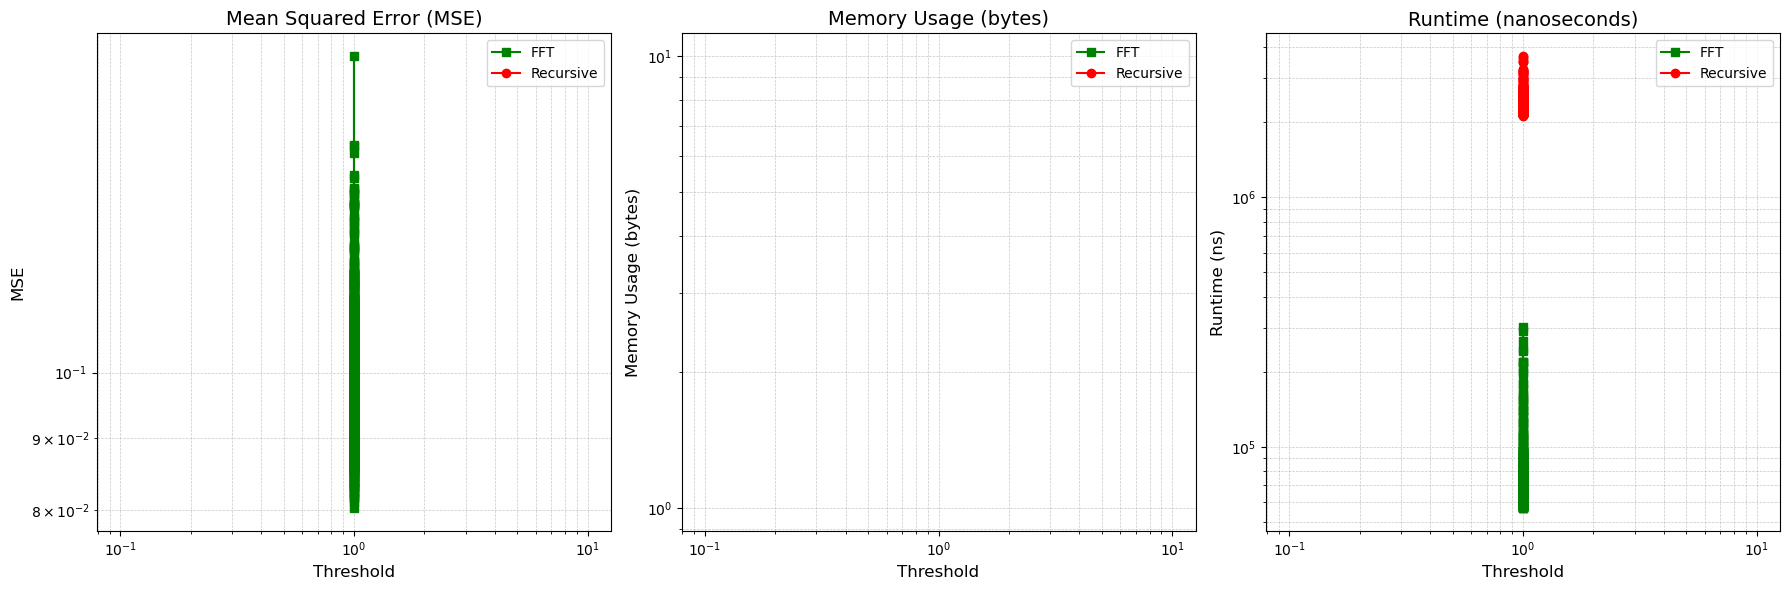

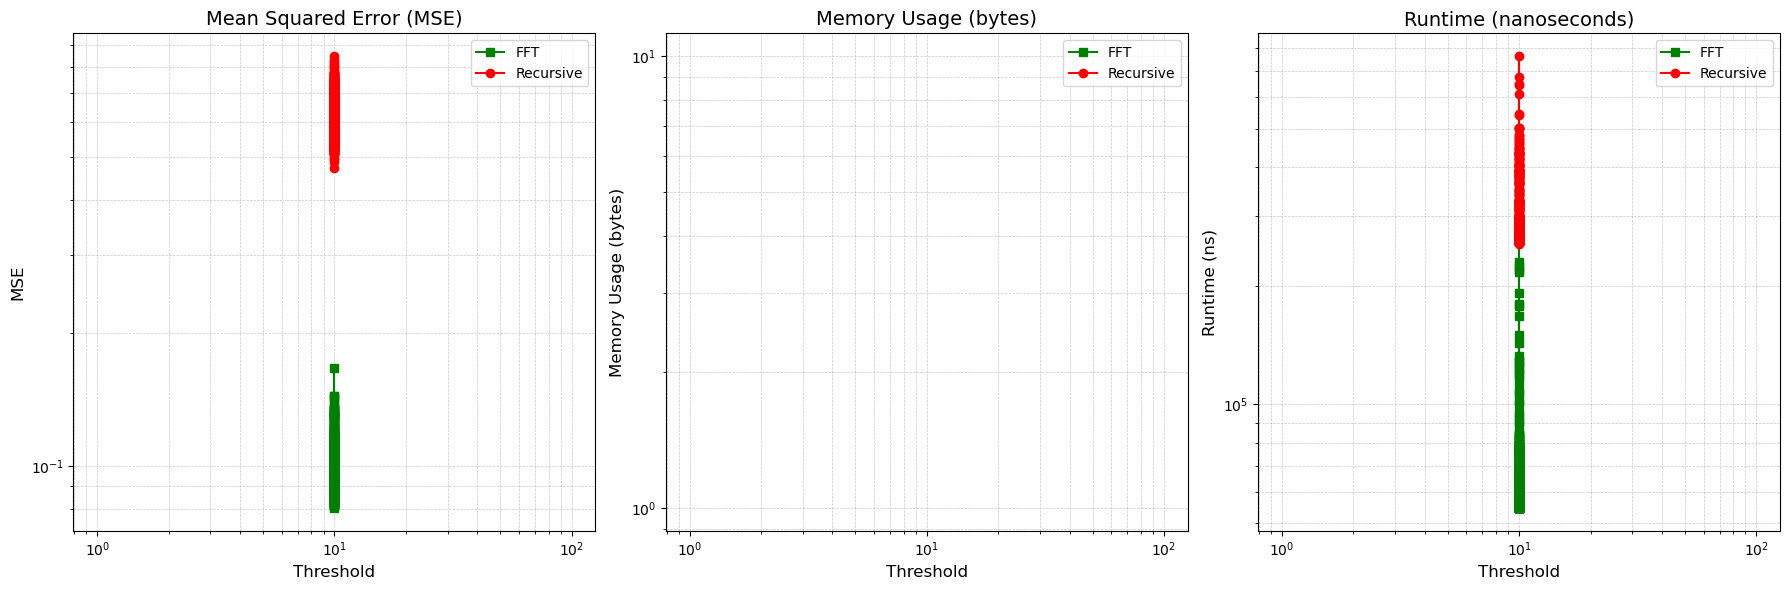

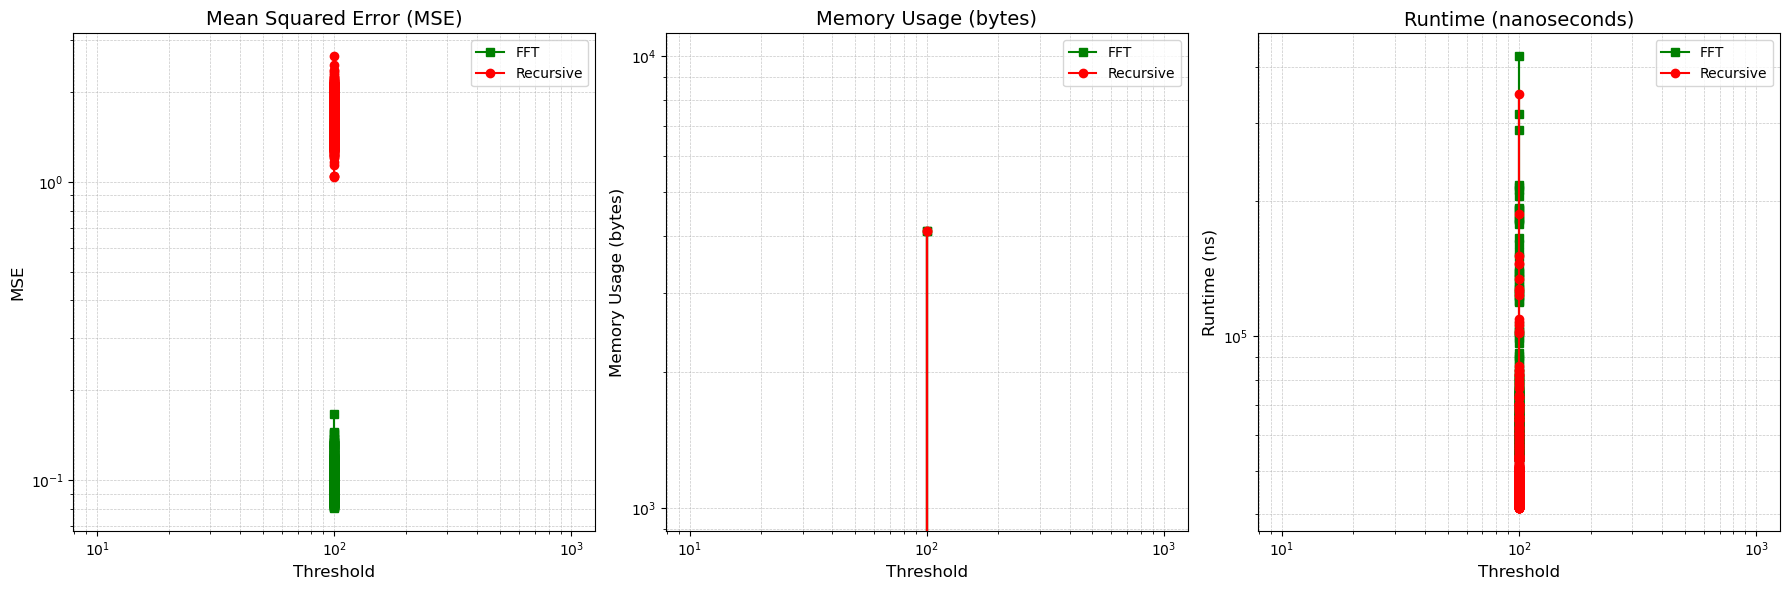

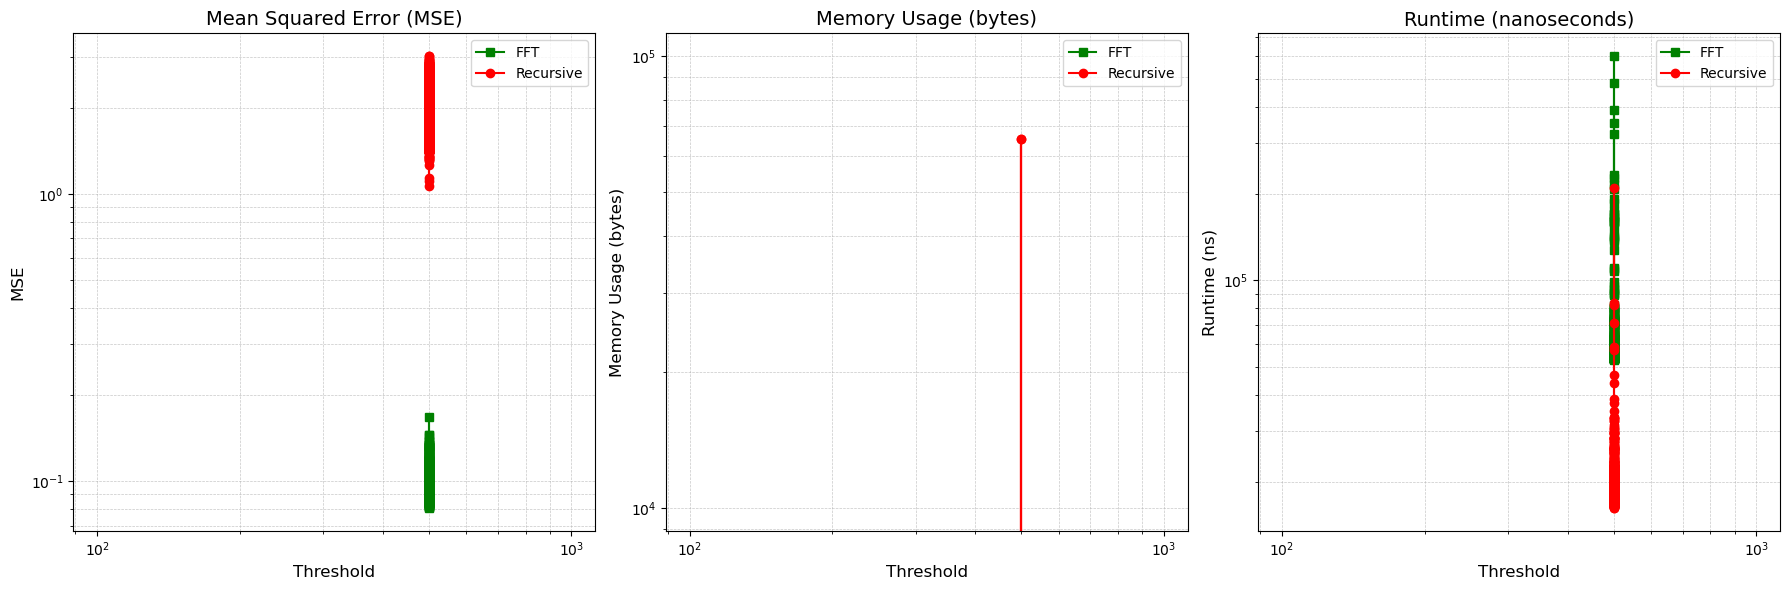

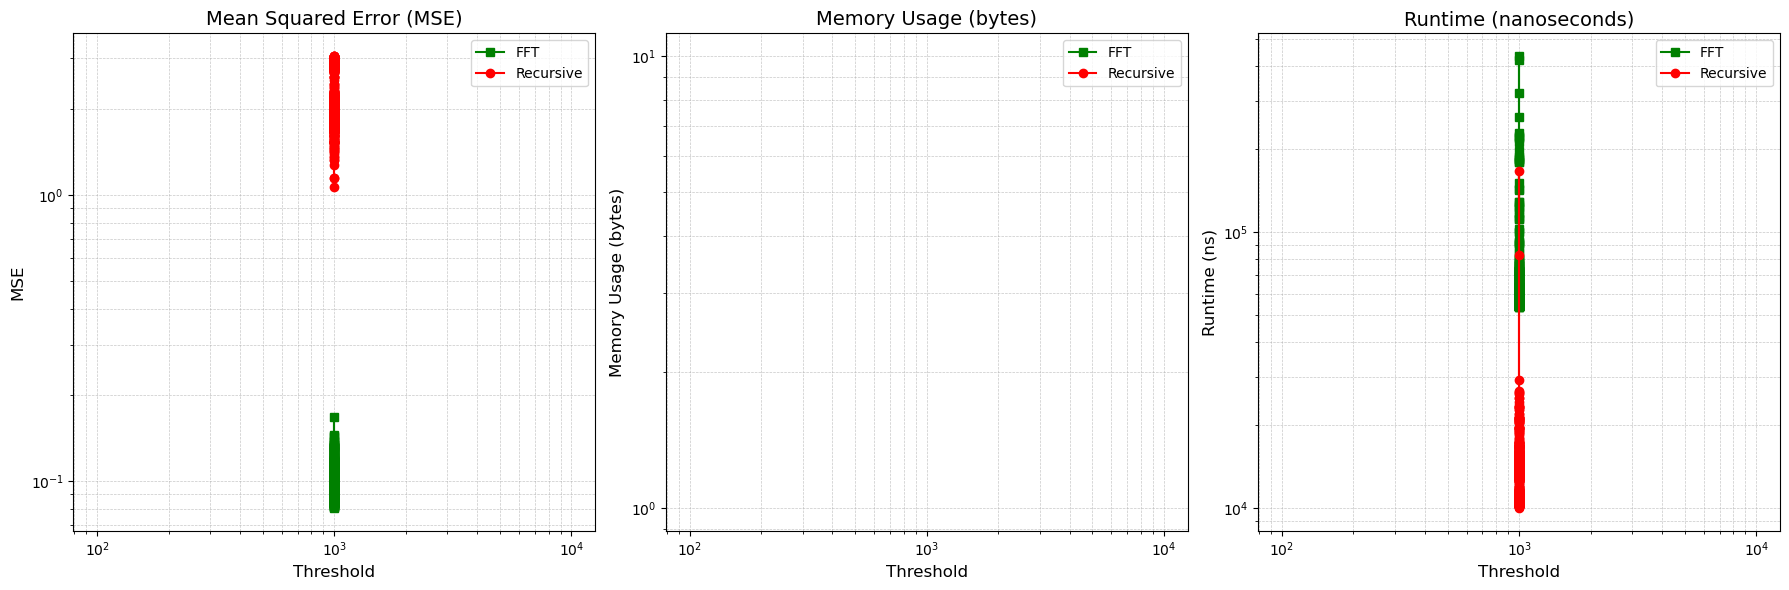

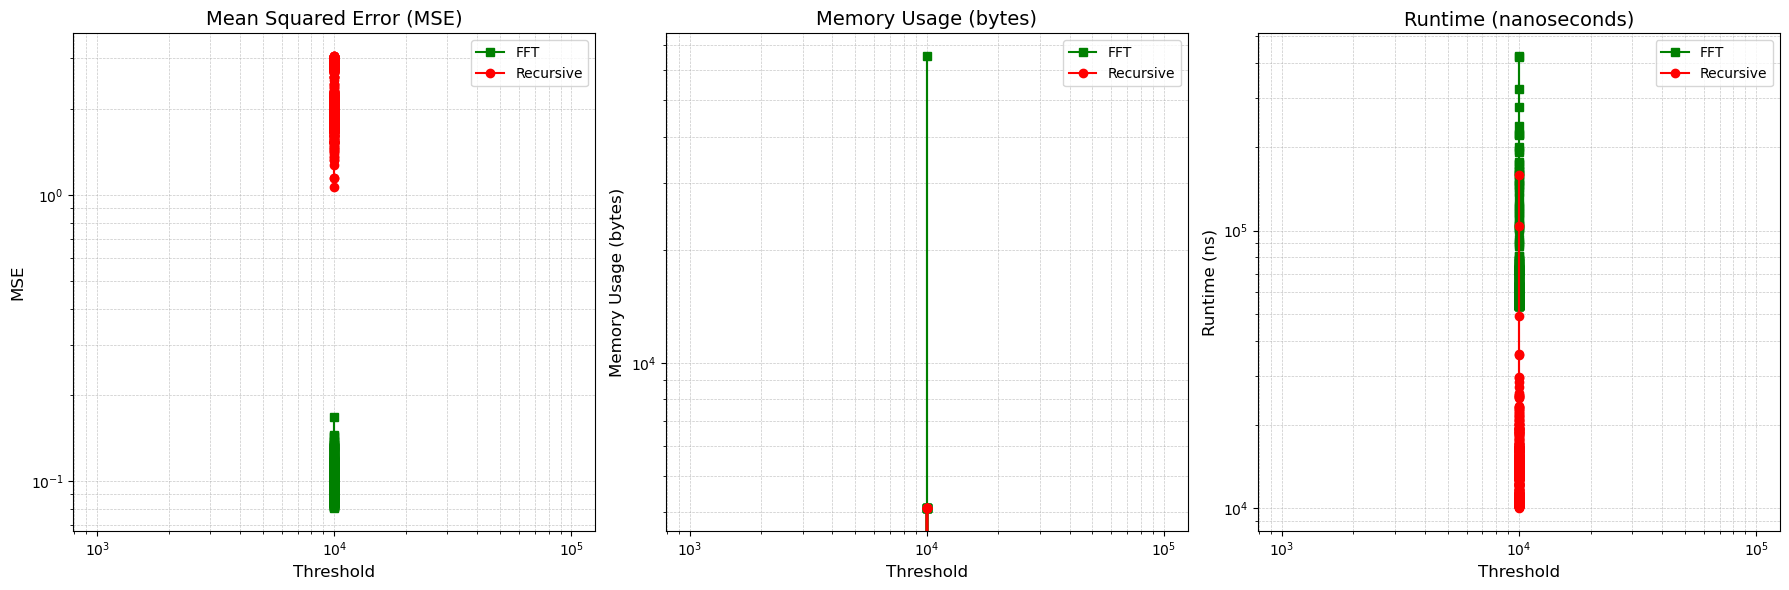

In [56]:
# ------------------ 5. Execute the Experiment Loop ------------------

# Initialize a dictionary to store results
results = {
    "Threshold": [],
    "FFT_MSE": [],
    "Recursive_MSE": [],
    "FFT_Memory": [],
    "Recursive_Memory": [],
    "FFT_Runtime": [],
    "Recursive_Runtime": [],
    "FFT_PSNR": [],
    "Recursive_PSNR": []
}

# Define possible thresholds
possible_thresholds = [1, 10, 100, 500, 1000, 10000]

# Iterate over each threshold
for threshold in possible_thresholds:
    print(f"\nRunning experiments for Threshold = {threshold}")
    # Iterate over each data point with a progress bar
    for i in tqdm(range(len(data)), desc=f"Threshold {threshold}"):
        # Extract the i-th time series
        time_series = data[i, :]
        
        # Process the time series and capture metrics
        (mse_fft, mse_gbrt, memory_fft, memory_gbrt,
         runtime_fft, runtime_gbrt, fft_psnr, gbrt_psnr) = func_kaggle(
            data=time_series,
            THRESHOLD=threshold
        )
        
        # Store the results
        results["Threshold"].append(threshold)
        results["FFT_MSE"].append(mse_fft)
        results["Recursive_MSE"].append(mse_gbrt)
        results["FFT_Memory"].append(memory_fft)
        results["Recursive_Memory"].append(memory_gbrt)
        results["FFT_Runtime"].append(runtime_fft)
        results["Recursive_Runtime"].append(runtime_gbrt)
        results["FFT_PSNR"].append(fft_psnr)
        results["Recursive_PSNR"].append(gbrt_psnr)

# Convert the results to a pandas DataFrame
pd_results = pd.DataFrame(results)

# Order the columns for better readability
pd_results = pd_results[[
    "Threshold",
    "FFT_MSE", "Recursive_MSE",
    "FFT_Memory", "Recursive_Memory",
    "FFT_Runtime", "Recursive_Runtime",
    "FFT_PSNR", "Recursive_PSNR"
]]

# Save the results for each threshold
for threshold in possible_thresholds:
    subset = pd_results[pd_results["Threshold"] == threshold]
    subset.to_csv(f"results_threshold_{threshold}.csv", index=False)
    plot_results(pd_results=subset)


   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

Threshold 1:   3%|▎         | 32/1000 [00:00<00:03, 318.96it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.110131            
PSNR           inf                 9.58                
Memory (bytes) 0                   0                   
Runtime (ns)   2995400             164000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.111211            
PSNR           inf                 9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   2385900             75000               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.087748            
PSNR           inf                 10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   2437400             69900               
Summary of Results
------------------
Metric  

Threshold 1:   7%|▋         | 66/1000 [00:00<00:02, 328.37it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.096907            
PSNR           inf                 10.14               
Memory (bytes) 0                   0                   
Runtime (ns)   2826200             73900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.105945            
PSNR           inf                 9.75                
Memory (bytes) 0                   0                   
Runtime (ns)   2295000             71000               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.100706            
PSNR           inf                 9.97                
Memory (bytes) 0                   0                   
Runtime (ns)   2515400             59300               
Summary of Results
------------------
Metric  

Threshold 1:  10%|▉         | 99/1000 [00:00<00:02, 326.87it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.092351            
PSNR           inf                 10.35               
Memory (bytes) 0                   0                   
Runtime (ns)   3429300             127600              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.100389            
PSNR           inf                 9.98                
Memory (bytes) 0                   0                   
Runtime (ns)   2323400             70200               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.094410            
PSNR           inf                 10.25               
Memory (bytes) 0                   0                   
Runtime (ns)   2188900             84400               
Summary of Results
------------------
Metric  

Threshold 1:  17%|█▋        | 167/1000 [00:00<00:02, 330.64it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.097410            
PSNR           inf                 10.11               
Memory (bytes) 0                   0                   
Runtime (ns)   3138300             62600               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.082194            
PSNR           inf                 10.85               
Memory (bytes) 0                   0                   
Runtime (ns)   2337200             61700               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.091820            
PSNR           inf                 10.37               
Memory (bytes) 0                   0                   
Runtime (ns)   2262700             59800               
Summary of Results
------------------
Metric  

Threshold 1:  24%|██▎       | 235/1000 [00:00<00:02, 333.87it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.094249            
PSNR           inf                 10.26               
Memory (bytes) 0                   0                   
Runtime (ns)   3133500             91200               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.089197            
PSNR           inf                 10.50               
Memory (bytes) 0                   0                   
Runtime (ns)   2521800             61000               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.104928            
PSNR           inf                 9.79                
Memory (bytes) 0                   0                   
Runtime (ns)   2166800             58500               
Summary of Results
------------------
Metric  

Threshold 1:  30%|███       | 303/1000 [00:00<00:02, 331.41it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.104940            
PSNR           inf                 9.79                
Memory (bytes) 0                   0                   
Runtime (ns)   2930100             74700               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.109225            
PSNR           inf                 9.62                
Memory (bytes) 0                   0                   
Runtime (ns)   2361600             61100               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.106805            
PSNR           inf                 9.71                
Memory (bytes) 0                   0                   
Runtime (ns)   2171000             58100               
Summary of Results
------------------
Metric  

Threshold 1:  37%|███▋      | 371/1000 [00:01<00:01, 331.85it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.087223            
PSNR           inf                 10.59               
Memory (bytes) 0                   0                   
Runtime (ns)   2995700             61800               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.087921            
PSNR           inf                 10.56               
Memory (bytes) 0                   0                   
Runtime (ns)   2389900             61000               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.094707            
PSNR           inf                 10.24               
Memory (bytes) 0                   0                   
Runtime (ns)   2171800             59100               
Summary of Results
------------------
Metric  

Threshold 1:  47%|████▋     | 472/1000 [00:01<00:01, 327.95it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.100065            
PSNR           inf                 10.00               
Memory (bytes) 0                   0                   
Runtime (ns)   2949500             104000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.098983            
PSNR           inf                 10.04               
Memory (bytes) 0                   0                   
Runtime (ns)   2645800             177200              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.101326            
PSNR           inf                 9.94                
Memory (bytes) 0                   0                   
Runtime (ns)   2173200             60000               
Summary of Results
------------------
Metric  

Threshold 1:  54%|█████▍    | 539/1000 [00:01<00:01, 330.26it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.092936            
PSNR           inf                 10.32               
Memory (bytes) 0                   0                   
Runtime (ns)   2515500             335900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.089683            
PSNR           inf                 10.47               
Memory (bytes) 0                   0                   
Runtime (ns)   2326400             60900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.097898            
PSNR           inf                 10.09               
Memory (bytes) 0                   0                   
Runtime (ns)   2179900             58400               
Summary of Results
------------------
Metric  

Threshold 1:  61%|██████    | 606/1000 [00:01<00:01, 329.13it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.102072            
PSNR           inf                 9.91                
Memory (bytes) 0                   0                   
Runtime (ns)   2419500             66300               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.099240            
PSNR           inf                 10.03               
Memory (bytes) 0                   0                   
Runtime (ns)   2405300             156900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.081151            
PSNR           inf                 10.91               
Memory (bytes) 0                   0                   
Runtime (ns)   2170400             59400               
Summary of Results
------------------
Metric  

Threshold 1:  67%|██████▋   | 672/1000 [00:02<00:01, 324.06it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.090479            
PSNR           inf                 10.43               
Memory (bytes) 0                   0                   
Runtime (ns)   2158900             61800               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.089659            
PSNR           inf                 10.47               
Memory (bytes) 0                   0                   
Runtime (ns)   2333800             60600               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.105359            
PSNR           inf                 9.77                
Memory (bytes) 0                   0                   
Runtime (ns)   2286400             59700               
Summary of Results
------------------
Metric  

Threshold 1:  74%|███████▍  | 739/1000 [00:02<00:00, 326.99it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.091466            
PSNR           inf                 10.39               
Memory (bytes) 0                   0                   
Runtime (ns)   2950100             64200               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.099222            
PSNR           inf                 10.03               
Memory (bytes) 0                   0                   
Runtime (ns)   2471400             61900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.103953            
PSNR           inf                 9.83                
Memory (bytes) 0                   0                   
Runtime (ns)   2177300             65200               
Summary of Results
------------------
Metric  

Threshold 1:  81%|████████  | 806/1000 [00:02<00:00, 325.53it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.100566            
PSNR           inf                 9.98                
Memory (bytes) 0                   0                   
Runtime (ns)   2571800             125100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.090662            
PSNR           inf                 10.43               
Memory (bytes) 0                   0                   
Runtime (ns)   2388400             78100               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.101306            
PSNR           inf                 9.94                
Memory (bytes) 0                   0                   
Runtime (ns)   2179300             92400               
Summary of Results
------------------
Metric  

Threshold 1:  87%|████████▋ | 872/1000 [00:02<00:00, 326.84it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.093683            
PSNR           inf                 10.28               
Memory (bytes) 0                   0                   
Runtime (ns)   2994900             224400              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.092464            
PSNR           inf                 10.34               
Memory (bytes) 0                   0                   
Runtime (ns)   2569200             94700               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.103820            
PSNR           inf                 9.84                
Memory (bytes) 0                   0                   
Runtime (ns)   2281500             61600               
Summary of Results
------------------
Metric  

Threshold 1:  94%|█████████▍| 940/1000 [00:02<00:00, 332.15it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.085204            
PSNR           inf                 10.70               
Memory (bytes) 0                   0                   
Runtime (ns)   2716900             174300              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.100297            
PSNR           inf                 9.99                
Memory (bytes) 0                   0                   
Runtime (ns)   2408200             62400               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.119700            
PSNR           inf                 9.22                
Memory (bytes) 0                   0                   
Runtime (ns)   2176200             59500               
Summary of Results
------------------
Metric  

Threshold 1: 100%|██████████| 1000/1000 [00:03<00:00, 329.18it/s]


Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.110558            
PSNR           inf                 9.56                
Memory (bytes) 0                   0                   
Runtime (ns)   2495600             202900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.098163            
PSNR           inf                 10.08               
Memory (bytes) 0                   0                   
Runtime (ns)   2118800             60700               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.000000            0.105147            
PSNR           inf                 9.78                
Memory (bytes) 0                   0                   
Runtime (ns)   2178700             58500               
Summary of Results
------------------
Metric  

Threshold 10:  10%|█         | 102/1000 [00:00<00:00, 1015.33it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.645185            0.110131            
PSNR           1.90                9.58                
Memory (bytes) 0                   0                   
Runtime (ns)   634000              148000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.592827            0.111211            
PSNR           2.27                9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   341300              63900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.566759            0.087748            
PSNR           2.47                10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   268300              58200               
Summary of Results
------------------
Metric  

Threshold 10:  32%|███▏      | 317/1000 [00:00<00:00, 1058.06it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.704835            0.091255            
PSNR           1.52                10.40               
Memory (bytes) 0                   0                   
Runtime (ns)   273200              388900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.590085            0.092254            
PSNR           2.29                10.35               
Memory (bytes) 0                   0                   
Runtime (ns)   382600              60000               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.619172            0.098673            
PSNR           2.08                10.06               
Memory (bytes) 0                   0                   
Runtime (ns)   263900              59400               
Summary of Results
------------------
Metric  

Threshold 10:  63%|██████▎   | 633/1000 [00:00<00:00, 1037.64it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.619587            0.098234            
PSNR           2.08                10.08               
Memory (bytes) 0                   0                   
Runtime (ns)   387800              65900               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.631491            0.102966            
PSNR           2.00                9.87                
Memory (bytes) 0                   0                   
Runtime (ns)   550100              196100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.641303            0.097337            
PSNR           1.93                10.12               
Memory (bytes) 0                   0                   
Runtime (ns)   273400              58700               
Summary of Results
------------------
Metric  

Threshold 10:  84%|████████▍ | 844/1000 [00:00<00:00, 1037.28it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.624783            0.098304            
PSNR           2.04                10.07               
Memory (bytes) 0                   0                   
Runtime (ns)   401200              188500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.609691            0.087812            
PSNR           2.15                10.56               
Memory (bytes) 0                   0                   
Runtime (ns)   396300              60500               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.621988            0.107139            
PSNR           2.06                9.70                
Memory (bytes) 0                   0                   
Runtime (ns)   263100              57000               
Summary of Results
------------------
Metric  

Threshold 10: 100%|██████████| 1000/1000 [00:00<00:00, 1033.01it/s]


Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.515072            0.094660            
PSNR           2.88                10.24               
Memory (bytes) 0                   0                   
Runtime (ns)   480200              215900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.615420            0.094648            
PSNR           2.11                10.24               
Memory (bytes) 0                   0                   
Runtime (ns)   306400              156400              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            0.676016            0.093580            
PSNR           1.70                10.29               
Memory (bytes) 0                   0                   
Runtime (ns)   261900              58500               
Summary of Results
------------------
Metric  

Threshold 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.424999            0.110131            
PSNR           -1.54               9.58                
Memory (bytes) 0                   0                   
Runtime (ns)   66700               206000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.377103            0.111211            
PSNR           -1.39               9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   122100              63700               
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.365444            0.087748            
PSNR           -1.35               10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   49800               71400               
Summary of Results
------------------
Metric  

Threshold 100:  28%|██▊       | 280/1000 [00:00<00:00, 1390.87it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.832121            0.100477            
PSNR           -2.63               9.98                
Memory (bytes) 0                   0                   
Runtime (ns)   43000               283700              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.473509            0.102744            
PSNR           -1.68               9.88                
Memory (bytes) 0                   0                   
Runtime (ns)   64300               149700              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.227289            0.083589            
PSNR           -0.89               10.78               
Memory (bytes) 0                   0                   
Runtime (ns)   48500               58500               
Summary of Results
------------------
Metric  

Threshold 100:  57%|█████▋    | 566/1000 [00:00<00:00, 1405.53it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.992555            0.101132            
PSNR           -2.99               9.95                
Memory (bytes) 0                   0                   
Runtime (ns)   92000               403400              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.675801            0.089493            
PSNR           -2.24               10.48               
Memory (bytes) 0                   0                   
Runtime (ns)   104800              169000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.923688            0.106569            
PSNR           -2.84               9.72                
Memory (bytes) 0                   0                   
Runtime (ns)   55600               65800               
Summary of Results
------------------
Metric  

Threshold 100:  85%|████████▌ | 851/1000 [00:00<00:00, 1396.73it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.193205            0.103605            
PSNR           -3.41               9.85                
Memory (bytes) 0                   0                   
Runtime (ns)   42300               429500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.418766            0.108670            
PSNR           -1.52               9.64                
Memory (bytes) 0                   0                   
Runtime (ns)   63500               159900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.528112            0.104231            
PSNR           -1.84               9.82                
Memory (bytes) 0                   0                   
Runtime (ns)   51500               185000              
Summary of Results
------------------
Metric  

Threshold 100: 100%|██████████| 1000/1000 [00:00<00:00, 1386.29it/s]


Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.712850            0.090468            
PSNR           -2.34               10.44               
Memory (bytes) 0                   65536               
Runtime (ns)   41900               366900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.865601            0.105933            
PSNR           -2.71               9.75                
Memory (bytes) 0                   0                   
Runtime (ns)   55800               169000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.561389            0.112025            
PSNR           -1.94               9.51                
Memory (bytes) 0                   0                   
Runtime (ns)   44700               57600               
Summary of Results
------------------
Metric  

Threshold 500:   0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.531026            0.110131            
PSNR           -1.85               9.58                
Memory (bytes) 0                   0                   
Runtime (ns)   30600               230900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.587266            0.111211            
PSNR           -2.01               9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   28400               203700              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.539071            0.087748            
PSNR           -1.87               10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   20600               173000              
Summary of Results
------------------
Metric  

Threshold 500:  14%|█▍        | 144/1000 [00:00<00:00, 1432.51it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.369086            0.099563            
PSNR           -3.75               10.02               
Memory (bytes) 0                   0                   
Runtime (ns)   24800               160100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.491994            0.106101            
PSNR           -1.74               9.74                
Memory (bytes) 0                   0                   
Runtime (ns)   23100               108300              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.846523            0.095585            
PSNR           -2.66               10.20               
Memory (bytes) 0                   0                   
Runtime (ns)   20900               57000               
Summary of Results
------------------
Metric  

Threshold 500:  29%|██▉       | 288/1000 [00:00<00:00, 1416.02it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.825907            0.101219            
PSNR           -2.61               9.95                
Memory (bytes) 0                   0                   
Runtime (ns)   24800               327600              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.708334            0.100569            
PSNR           -4.33               9.98                
Memory (bytes) 0                   0                   
Runtime (ns)   23300               138600              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.221776            0.097798            
PSNR           -3.47               10.10               
Memory (bytes) 0                   0                   
Runtime (ns)   22400               61500               
Summary of Results
------------------
Metric  

Threshold 500:  44%|████▍     | 439/1000 [00:00<00:00, 1454.77it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.604438            0.106180            
PSNR           -4.16               9.74                
Memory (bytes) 0                   0                   
Runtime (ns)   30700               345200              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.232841            0.093003            
PSNR           -3.49               10.32               
Memory (bytes) 0                   0                   
Runtime (ns)   32700               153000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.913669            0.096953            
PSNR           -2.82               10.13               
Memory (bytes) 0                   0                   
Runtime (ns)   18800               60000               
Summary of Results
------------------
Metric  

Threshold 500:  74%|███████▍  | 740/1000 [00:00<00:00, 1465.87it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.140012            0.144466            
PSNR           -0.57               8.40                
Memory (bytes) 0                   4096                
Runtime (ns)   34900               412600              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.886883            0.099073            
PSNR           -2.76               10.04               
Memory (bytes) 0                   0                   
Runtime (ns)   28000               266500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.132073            0.102072            
PSNR           -3.29               9.91                
Memory (bytes) 0                   0                   
Runtime (ns)   24800               63800               
Summary of Results
------------------
Metric  

Threshold 500: 100%|██████████| 1000/1000 [00:00<00:00, 1454.24it/s]


Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.566205            0.104282            
PSNR           -4.09               9.82                
Memory (bytes) 0                   0                   
Runtime (ns)   21300               399900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.911900            0.082895            
PSNR           -2.81               10.81               
Memory (bytes) 0                   0                   
Runtime (ns)   35500               175900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.167521            0.106268            
PSNR           -3.36               9.74                
Memory (bytes) 0                   0                   
Runtime (ns)   22500               57600               
Summary of Results
------------------
Metric  

Threshold 1000:   0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.733512            0.110131            
PSNR           -2.39               9.58                
Memory (bytes) 0                   0                   
Runtime (ns)   25500               247900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.642723            0.111211            
PSNR           -2.16               9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   24700               171800              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.166207            0.087748            
PSNR           -3.36               10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   12200               63300               
Summary of Results
------------------
Metric  

Threshold 1000:  14%|█▍        | 145/1000 [00:00<00:00, 1439.07it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            3.002353            0.086977            
PSNR           -4.77               10.61               
Memory (bytes) 0                   0                   
Runtime (ns)   18200               458200              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.865277            0.088612            
PSNR           -2.71               10.53               
Memory (bytes) 0                   0                   
Runtime (ns)   24900               188400              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.056139            0.101760            
PSNR           -3.13               9.92                
Memory (bytes) 0                   0                   
Runtime (ns)   14800               62300               
Summary of Results
------------------
Metric  

Threshold 1000:  29%|██▉       | 290/1000 [00:00<00:00, 1441.05it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.988566            0.095852            
PSNR           -4.75               10.18               
Memory (bytes) 0                   0                   
Runtime (ns)   15600               357800              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.989419            0.087880            
PSNR           -4.76               10.56               
Memory (bytes) 0                   0                   
Runtime (ns)   19200               134800              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.885095            0.081922            
PSNR           -4.60               10.87               
Memory (bytes) 0                   0                   
Runtime (ns)   17300               177800              
Summary of Results
------------------
Metric  

Threshold 1000:  58%|█████▊    | 584/1000 [00:00<00:00, 1425.49it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.927480            0.094222            
PSNR           -2.85               10.26               
Memory (bytes) 0                   0                   
Runtime (ns)   16900               277900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.074373            0.089171            
PSNR           -3.17               10.50               
Memory (bytes) 0                   0                   
Runtime (ns)   15800               159200              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            3.006376            0.089682            
PSNR           -4.78               10.47               
Memory (bytes) 0                   0                   
Runtime (ns)   16200               57200               
Summary of Results
------------------
Metric  

Threshold 1000:  87%|████████▋ | 873/1000 [00:00<00:00, 1420.23it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.947181            0.090807            
PSNR           -4.69               10.42               
Memory (bytes) 0                   0                   
Runtime (ns)   33600               261800              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.025941            0.101327            
PSNR           -3.07               9.94                
Memory (bytes) 0                   0                   
Runtime (ns)   20300               170100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.961286            0.106813            
PSNR           -2.93               9.71                
Memory (bytes) 0                   0                   
Runtime (ns)   11900               64500               
Summary of Results
------------------
Metric  

Threshold 1000: 100%|██████████| 1000/1000 [00:00<00:00, 1418.94it/s]


Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.904860            0.087384            
PSNR           -2.80               10.59               
Memory (bytes) 0                   0                   
Runtime (ns)   18100               182900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.900524            0.099356            
PSNR           -4.62               10.03               
Memory (bytes) 0                   0                   
Runtime (ns)   15100               141500              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.990010            0.091782            
PSNR           -4.76               10.37               
Memory (bytes) 0                   0                   
Runtime (ns)   15100               66600               
Summary of Results
------------------
Metric  

Threshold 10000:  16%|█▌        | 155/1000 [00:00<00:00, 1541.94it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.733512            0.110131            
PSNR           -2.39               9.58                
Memory (bytes) 0                   0                   
Runtime (ns)   28500               165300              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.642723            0.111211            
PSNR           -2.16               9.54                
Memory (bytes) 0                   0                   
Runtime (ns)   24200               258400              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.166207            0.087748            
PSNR           -3.36               10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   12300               58000               
Summary of Results
------------------
Metric  

Threshold 10000:  31%|███       | 310/1000 [00:00<00:00, 1481.24it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.015985            0.094979            
PSNR           -3.04               10.22               
Memory (bytes) 0                   0                   
Runtime (ns)   15900               184200              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            1.747546            0.094449            
PSNR           -2.42               10.25               
Memory (bytes) 0                   0                   
Runtime (ns)   23800               237300              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            3.014231            0.100636            
PSNR           -4.79               9.97                
Memory (bytes) 0                   0                   
Runtime (ns)   21200               65500               
Summary of Results
------------------
Metric  

Threshold 10000:  46%|████▌     | 459/1000 [00:00<00:00, 1393.55it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.006874            0.083754            
PSNR           -3.03               10.77               
Memory (bytes) 0                   0                   
Runtime (ns)   25600               173600              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.924950            0.083035            
PSNR           -4.66               10.81               
Memory (bytes) 0                   0                   
Runtime (ns)   24700               157300              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.691569            0.105326            
PSNR           -4.30               9.77                
Memory (bytes) 0                   0                   
Runtime (ns)   15100               57100               
Summary of Results
------------------
Metric  

Threshold 10000:  60%|█████▉    | 599/1000 [00:00<00:00, 1387.07it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.069552            0.092765            
PSNR           -3.16               10.33               
Memory (bytes) 0                   0                   
Runtime (ns)   16300               523300              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.868331            0.106461            
PSNR           -4.58               9.73                
Memory (bytes) 0                   0                   
Runtime (ns)   15600               213100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.090303            0.087633            
PSNR           -3.20               10.57               
Memory (bytes) 0                   0                   
Runtime (ns)   15100               60300               
Summary of Results
------------------
Metric  

Threshold 10000:  76%|███████▌  | 755/1000 [00:00<00:00, 1444.09it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.283638            0.096914            
PSNR           -3.59               10.14               
Memory (bytes) 0                   0                   
Runtime (ns)   10500               363900              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.047878            0.091691            
PSNR           -3.11               10.38               
Memory (bytes) 0                   0                   
Runtime (ns)   23700               162100              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.896803            0.087119            
PSNR           -4.62               10.60               
Memory (bytes) 0                   0                   
Runtime (ns)   13300               159100              
Summary of Results
------------------
Metric  

Threshold 10000: 100%|██████████| 1000/1000 [00:00<00:00, 1449.35it/s]

Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.981007            0.097727            
PSNR           -4.74               10.10               
Memory (bytes) 0                   0                   
Runtime (ns)   12800               397000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.024539            0.099995            
PSNR           -3.06               10.00               
Memory (bytes) 0                   0                   
Runtime (ns)   23500               147000              
Summary of Results
------------------
Metric         Recursive           FFT                 
MSE            2.785061            0.095390            
PSNR           -4.45               10.20               
Memory (bytes) 0                   0                   
Runtime (ns)   11800               57200               
Summary of Results
------------------
Metric  

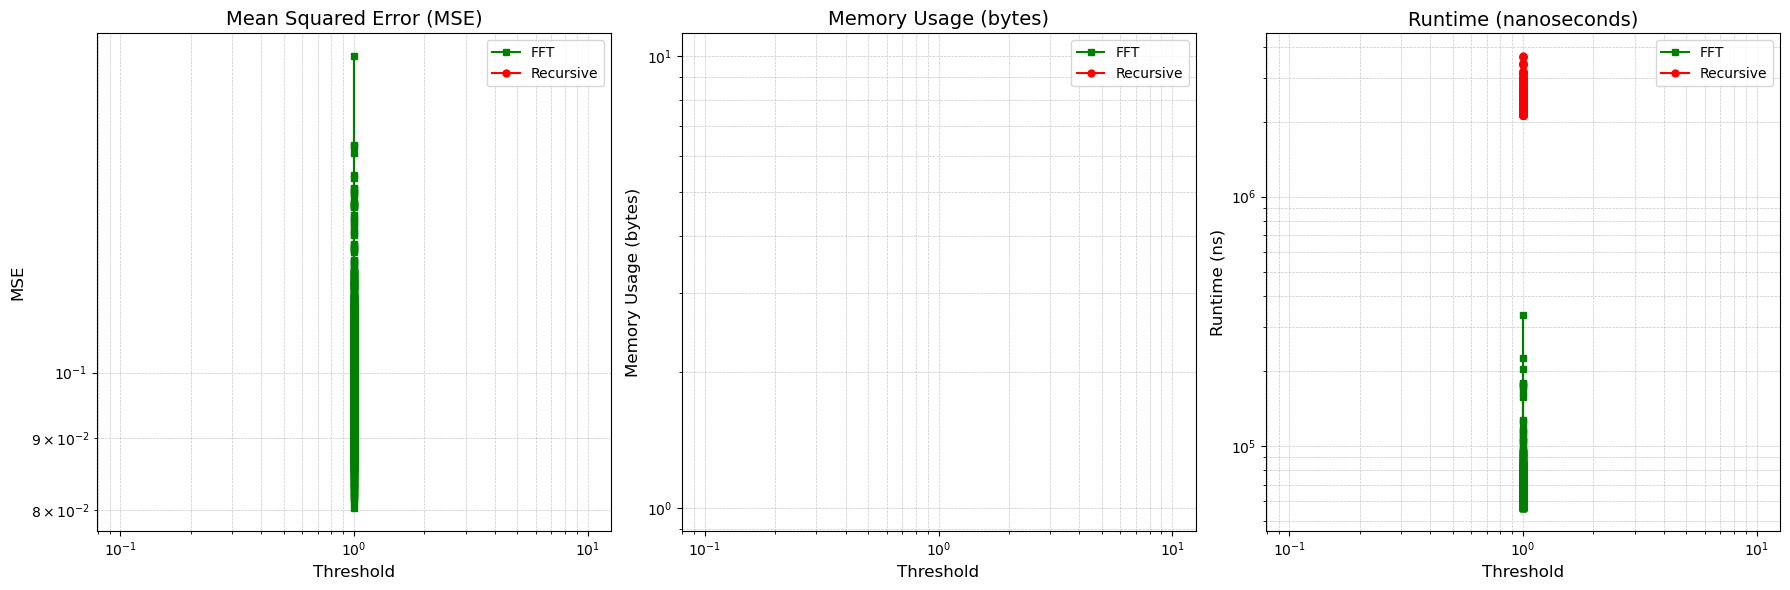

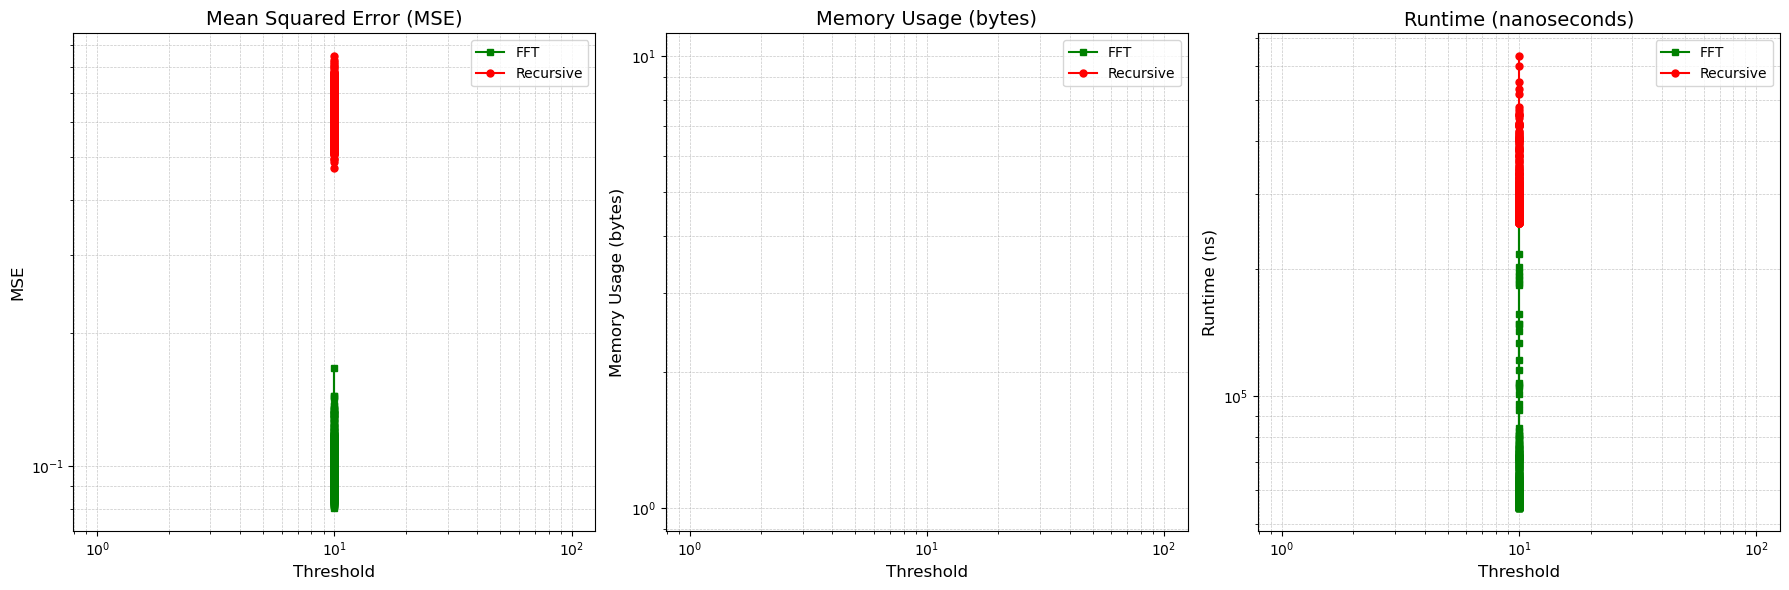

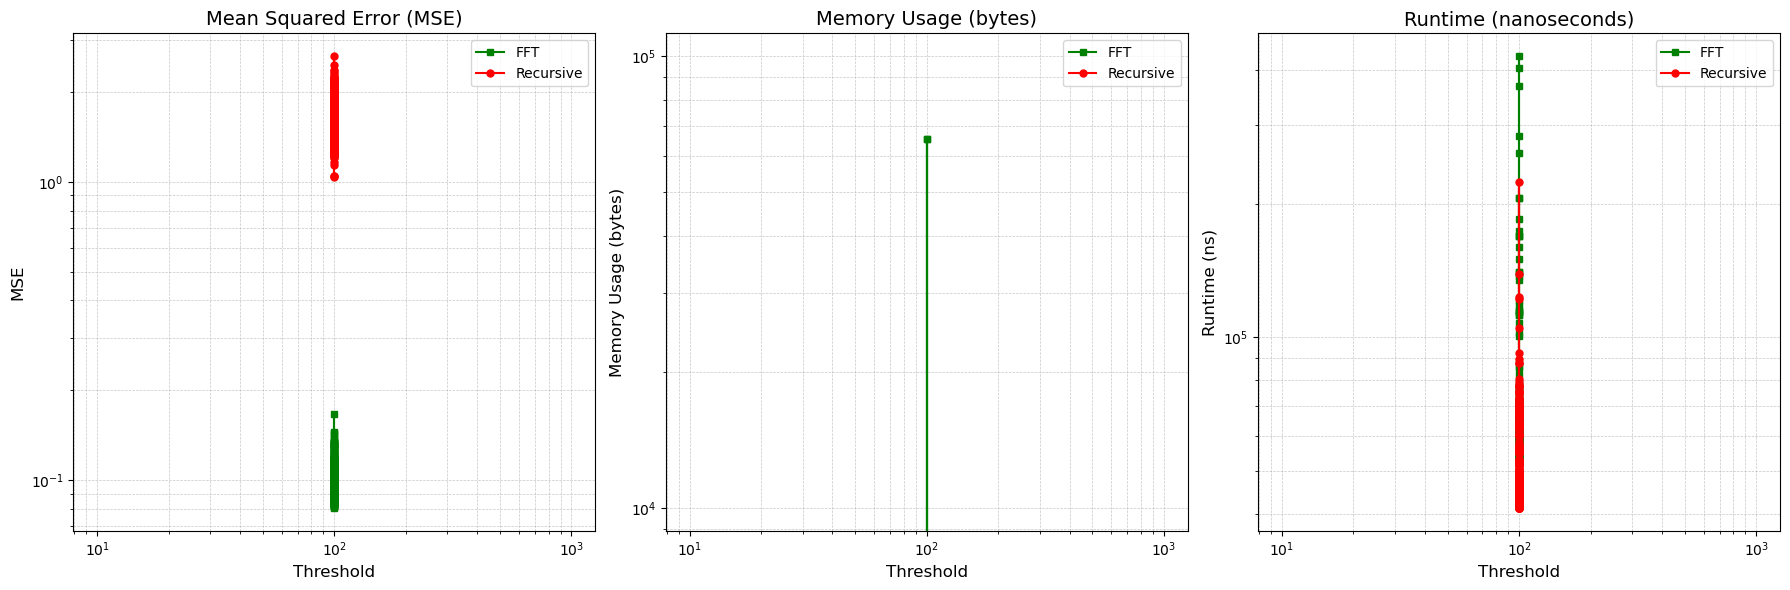

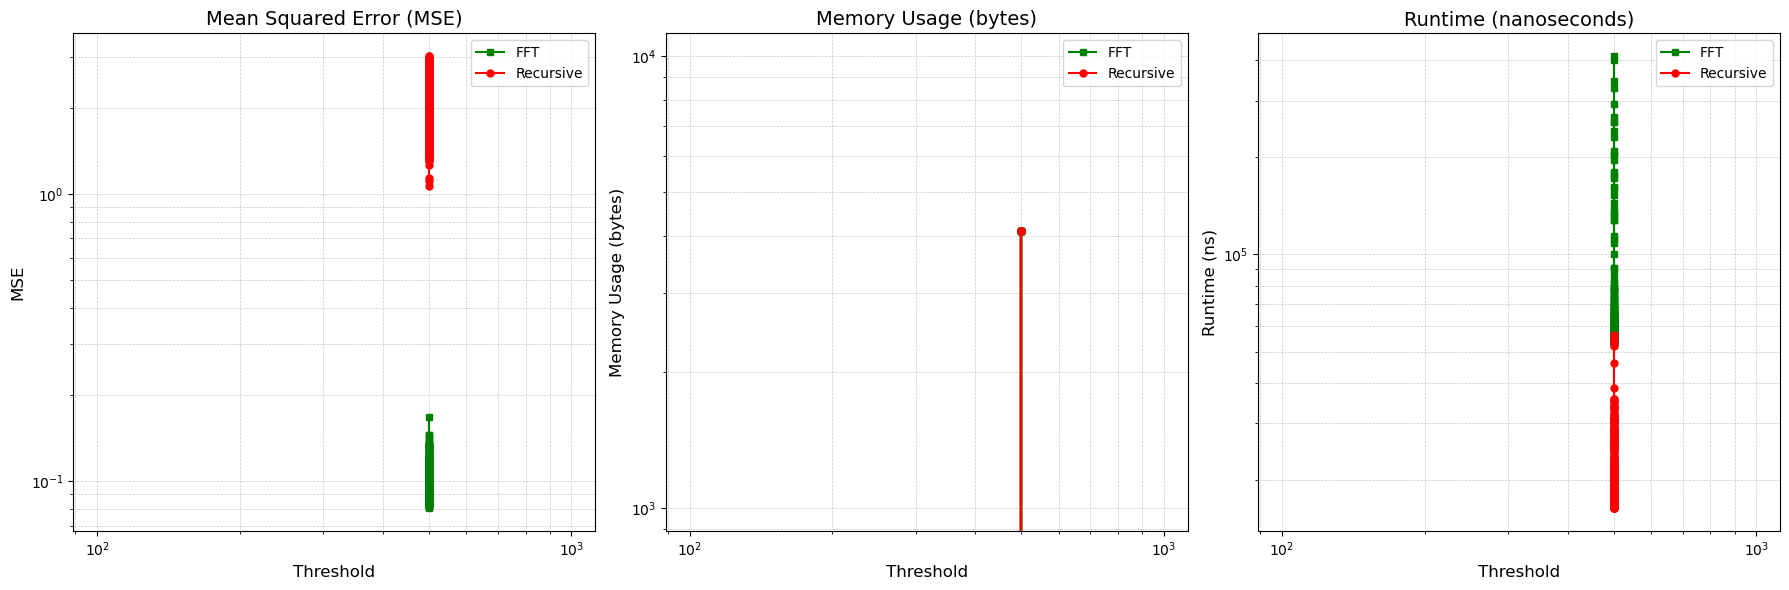

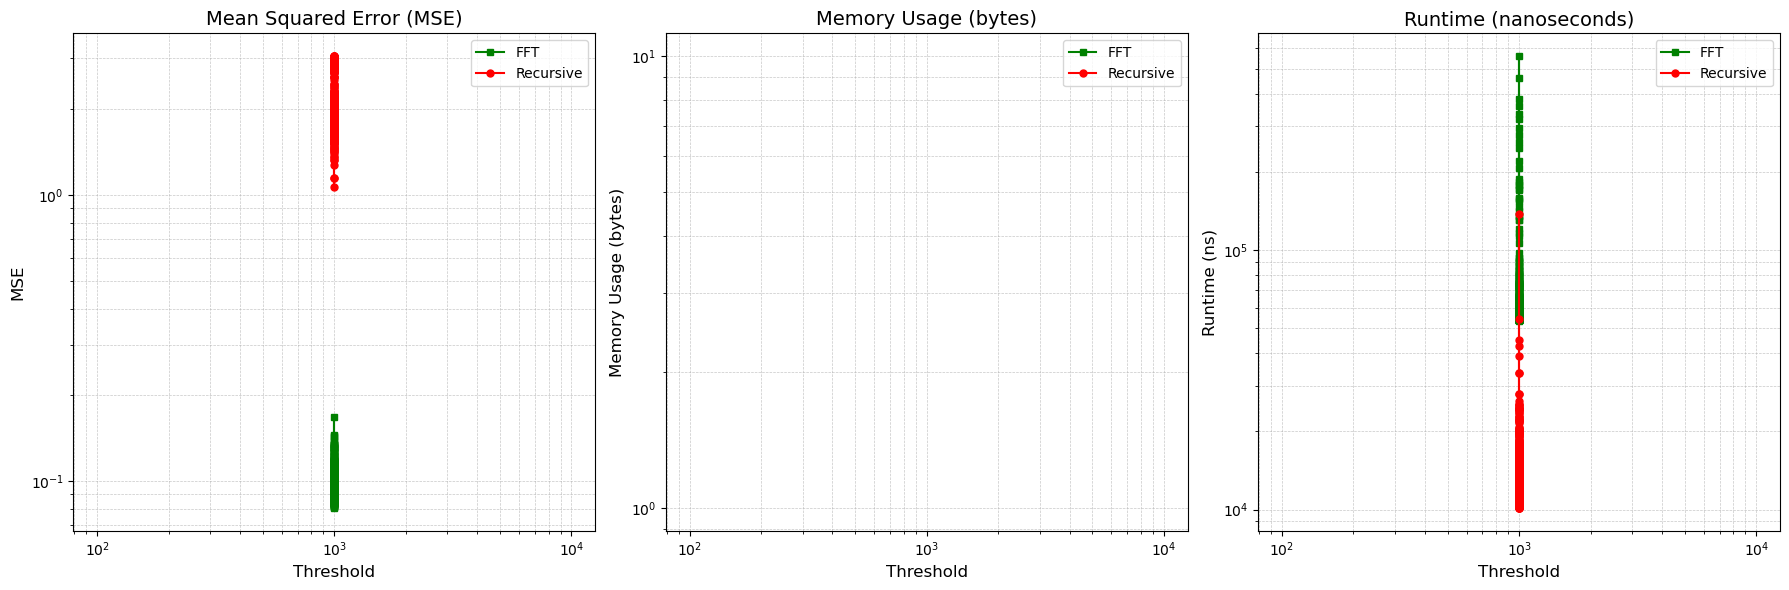

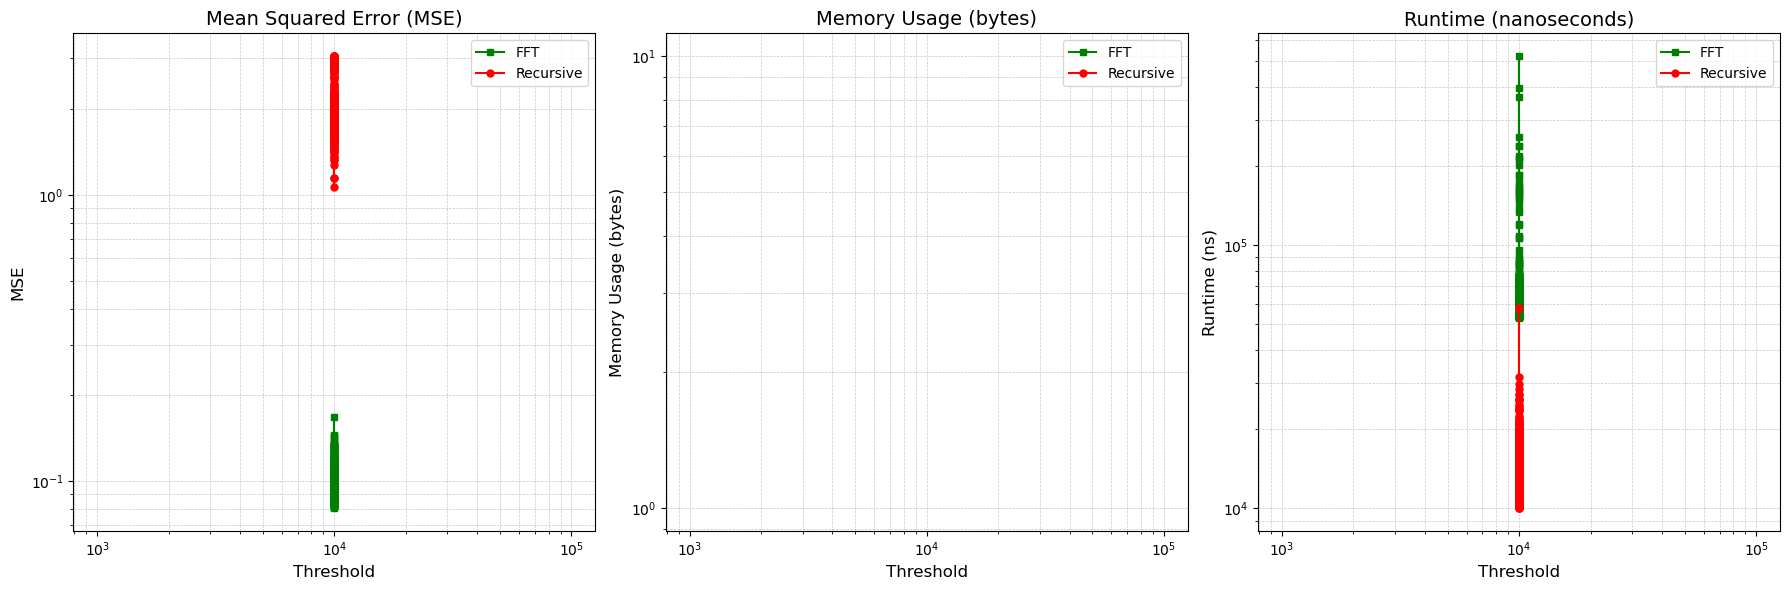

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from sklearn.metrics import mean_squared_error
import time
import sys
import psutil
from tqdm import tqdm  # For progress bars
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ------------------ 1. Define Necessary Functions ------------------

# Recursive Encoding Function
def recursive_encode(data, threshold=1000):
    """
    Recursively encodes the data by splitting it until each segment's length
    is less than or equal to the threshold. Each segment is represented by its maximum value.
    """
    if len(data) <= threshold:
        return [np.max(data)]  # Encoding with max value as a feature
    
    mid = len(data) // 2
    left_encoded = recursive_encode(data[:mid], threshold)
    right_encoded = recursive_encode(data[mid:], threshold)
    
    return left_encoded + right_encoded

# Recursive Decoding Function
def recursive_decode(encoded_data, original_length, threshold=1000):
    """
    Recursively decodes the encoded data by expanding each encoded value back to its segment length.
    """
    if len(encoded_data) == 1:
        return np.full(original_length, encoded_data[0])
    
    half_length = original_length // 2
    left_decoded = recursive_decode(encoded_data[:len(encoded_data)//2], half_length, threshold)
    right_decoded = recursive_decode(encoded_data[len(encoded_data)//2:], original_length - half_length, threshold)
    
    combined_decoded = np.concatenate((left_decoded, right_decoded))
    return combined_decoded[:original_length]  # Ensure consistent length

# FFT Encoding Function
def fft_encode(data, num_coefficients=50):
    """
    Encodes the data using FFT by retaining the top 'num_coefficients' frequency components.
    """
    fft_coeffs = fft(data)
    indices = np.argsort(np.abs(fft_coeffs))[-num_coefficients:]
    fft_compressed = np.zeros_like(fft_coeffs)
    fft_compressed[indices] = fft_coeffs[indices]
    return fft_compressed

# FFT Decoding Function
def fft_decode(compressed_fft):
    """
    Decodes the FFT-compressed data by performing an inverse FFT.
    """
    reconstructed = ifft(compressed_fft)
    return np.real(reconstructed)  # Discard the imaginary part

# Peak Signal-to-Noise Ratio Function
def psnr(true, pred):
    """
    Calculates the Peak Signal-to-Noise Ratio between the true and predicted signals.
    """
    mse = mean_squared_error(true, pred)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(1/mse)

# Memory Usage Function
def memory_usage(obj):
    """
    Estimates the memory usage of a Python object in bytes.
    """
    process = psutil.Process()
    mem_before = process.memory_info().rss
    _ = obj  # Reference the object
    mem_after = process.memory_info().rss
    return mem_after - mem_before  # Return memory used by the object

# Runtime Measurement Function
def measure_runtime(func, data, threshold=1000):
    """
    Measures the runtime of a function.
    """
    start_time = time.perf_counter_ns()
    func(data, threshold)
    end_time = time.perf_counter_ns()
    return end_time - start_time  # Runtime in nanoseconds

# ------------------ 2. Define the Main Processing Function ------------------

def func_kaggle(data: np.array, THRESHOLD=1000):
    """
    Processes the data using both Recursive Partitioning and FFT-based encoding/decoding.
    Returns performance metrics for both methods.
    """
    # Initialize metrics
    mse_gbrt = mse_fft = memory_gbrt = memory_fft = runtime_fft = runtime_gbrt = fft_psnr = gbrt_psnr = 0
    
    # Measure Recursive Partitioning
    start_time = time.perf_counter_ns()
    encoded = recursive_encode(data, threshold=THRESHOLD)
    decoded = recursive_decode(encoded, len(data), threshold=THRESHOLD)
    end_time = time.perf_counter_ns()
    runtime_gbrt = end_time - start_time  # in nanoseconds
    mse_gbrt = mean_squared_error(data, decoded)
    memory_gbrt = memory_usage(encoded)
    gbrt_psnr = psnr(data, decoded)
    
    # Measure FFT-based Encoding/Decoding
    start_time = time.perf_counter_ns()
    fft_encoded = fft_encode(data)
    fft_decoded = fft_decode(fft_encoded)
    end_time = time.perf_counter_ns()
    runtime_fft = end_time - start_time  # in nanoseconds
    mse_fft = mean_squared_error(data, fft_decoded)
    memory_fft = memory_usage(fft_encoded)
    fft_psnr = psnr(data, fft_decoded)
    
    # Print Summary of Results
    print("Summary of Results")
    print("------------------")
    print(f"{'Metric':<15}{'Recursive':<20}{'FFT':<20}")
    print(f"{'MSE':<15}{mse_gbrt:<20.6f}{mse_fft:<20.6f}")
    print(f"{'PSNR':<15}{gbrt_psnr:<20.2f}{fft_psnr:<20.2f}")
    print(f"{'Memory (bytes)':<15}{memory_gbrt:<20}{memory_fft:<20}")
    print(f"{'Runtime (ns)':<15}{runtime_gbrt:<20}{runtime_fft:<20}")
    
    return mse_fft, mse_gbrt, memory_fft, memory_gbrt, runtime_fft, runtime_gbrt, fft_psnr, gbrt_psnr

# ------------------ 3. Define the Plotting Function ------------------

def plot_results(pd_results):
    """
    Plots the MSE, Memory Usage, and Runtime for Recursive Partitioning and FFT-based methods.
    """
    # Define colors and markers for consistency
    colors = {'FFT': 'green', 'Recursive': 'red'}
    markers = {'FFT': 's', 'Recursive': 'o'}
    
    plt.figure(figsize=(18, 6))
    
    # ------------------ Subplot 1: MSE ------------------
    plt.subplot(1, 3, 1)
    plt.plot(pd_results["Threshold"], pd_results["FFT_MSE"], label="FFT", marker='s', color=colors['FFT'], markersize=5, linestyle='-')
    plt.plot(pd_results["Threshold"], pd_results["Recursive_MSE"], label="Recursive", marker='o', color=colors['Recursive'], markersize=5, linestyle='-')
    plt.title("Mean Squared Error (MSE)", fontsize=14)
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("MSE", fontsize=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
    
    # ------------------ Subplot 2: Memory Usage ------------------
    plt.subplot(1, 3, 2)
    plt.plot(pd_results["Threshold"], pd_results["FFT_Memory"], label="FFT", marker='s', color=colors['FFT'], markersize=5, linestyle='-')
    plt.plot(pd_results["Threshold"], pd_results["Recursive_Memory"], label="Recursive", marker='o', color=colors['Recursive'], markersize=5, linestyle='-')
    plt.title("Memory Usage (bytes)", fontsize=14)
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Memory Usage (bytes)", fontsize=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
    
    # ------------------ Subplot 3: Runtime ------------------
    plt.subplot(1, 3, 3)
    plt.plot(pd_results["Threshold"], pd_results["FFT_Runtime"], label="FFT", marker='s', color=colors['FFT'], markersize=5, linestyle='-')
    plt.plot(pd_results["Threshold"], pd_results["Recursive_Runtime"], label="Recursive", marker='o', color=colors['Recursive'], markersize=5, linestyle='-')
    plt.title("Runtime (nanoseconds)", fontsize=14)
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Runtime (ns)", fontsize=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()
    plt.savefig("runtime_memory_comparison_real_dataset.png", dpi=300)
    plt.show()
# ------------------ 4. Load and Preprocess the Dataset ------------------

import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('train.csv')

# Display the first few rows to understand the structure
print(data.head())

# Randomly select 1000 rows from the data for processing
data = data.sample(1000, random_state=42)  # Setting a random state for reproducibility

# Drop any rows with missing values
data = data.dropna()

# Reset the index after sampling
data = data.reset_index(drop=True)

# Convert the data to a NumPy array
data = data.to_numpy()

# Exclude the last two columns (assuming they are non-essential)
data = data[:, :-2]

print(f"Data shape after preprocessing: {data.shape}")

# ------------------ 5. Execute the Experiment Loop ------------------

# Initialize a dictionary to store results
results = {
    "Threshold": [],
    "FFT_MSE": [],
    "Recursive_MSE": [],
    "FFT_Memory": [],
    "Recursive_Memory": [],
    "FFT_Runtime": [],
    "Recursive_Runtime": [],
    "FFT_PSNR": [],
    "Recursive_PSNR": []
}

# Define possible thresholds
possible_thresholds = [1, 10, 100, 500, 1000, 10000]

# Iterate over each threshold
for threshold in possible_thresholds:
    print(f"\nRunning experiments for Threshold = {threshold}")
    # Iterate over each data point with a progress bar
    for i in tqdm(range(len(data)), desc=f"Threshold {threshold}"):
        # Extract the i-th time series
        time_series = data[i, :]
        
        # Process the time series and capture metrics
        (mse_fft, mse_gbrt, memory_fft, memory_gbrt,
         runtime_fft, runtime_gbrt, fft_psnr, gbrt_psnr) = func_kaggle(
            data=time_series,
            THRESHOLD=threshold
        )
        
        # Store the results
        results["Threshold"].append(threshold)
        results["FFT_MSE"].append(mse_fft)
        results["FFT_Memory"].append(memory_fft)
        results["FFT_Runtime"].append(runtime_fft)
        results["Recursive_MSE"].append(mse_gbrt)
        results["Recursive_Memory"].append(memory_gbrt)
        results["Recursive_Runtime"].append(runtime_gbrt)
        results["FFT_PSNR"].append(fft_psnr)
        results["Recursive_PSNR"].append(gbrt_psnr)

# Convert the results to a pandas DataFrame
pd_results = pd.DataFrame(results)

# Order the columns for better readability
pd_results = pd_results[[
    "Threshold",
    "FFT_MSE", "Recursive_MSE",
    "FFT_Memory", "Recursive_Memory",
    "FFT_Runtime", "Recursive_Runtime",
    "FFT_PSNR", "Recursive_PSNR"
]]

# Save the results for each threshold and plot
for threshold in possible_thresholds:
    subset = pd_results[pd_results["Threshold"] == threshold]
    subset.to_csv(f"results_threshold_{threshold}.csv", index=False)
    plot_results(pd_results=subset)

